# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

sb.set()

# Phase 1: Feature Importance Analysis with H2O AutoML Incorporating "artist_pop"

# Preparing Song Data for ML with "artist_pop"

We will first filter the data, such that it contains only the selected predictors.
+ duration_ms
+ artist_pop
+ liveness
+ loudness
+ speechiness
+ energy
+ tempo
+ acousticness
+ valence
+ danceability
+ key


In [2]:
# Load the dataset with specified columns only
predictors_df = pd.read_csv('Full_Dataset.csv', usecols=[
    'duration_ms', 'artist_pop', 'liveness', 'loudness', 'speechiness', 
    'energy', 'tempo', 'acousticness', 'valence', 'danceability', 'key', 'track_pop'
])


# Preprocessing Data (OneHotEncoding + Scaling) with "artist_pop"

In [3]:
# Separate features and the target 'track_pop' before applying transformations
features = predictors_df.drop('track_pop', axis=1)
target = predictors_df['track_pop']

In [4]:
# Setup OneHotEncoder within a ColumnTransformer for the 'key' column
column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['key'])  # OneHotEncode 'key' column
    ],
    remainder='passthrough'  # Leave other columns untouched
)

In [5]:
# Apply the ColumnTransformer to the features
processed_features = column_transformer.fit_transform(features)
feature_names = column_transformer.get_feature_names_out()


In [6]:
# Create a DataFrame for the processed data, including feature names
processed_df = pd.DataFrame(processed_features, columns=feature_names)


In [7]:
# Reattach the target variable 'track_pop' to the processed DataFrame
processed_df['track_pop'] = target

# Split the data into training and testing sets
X = processed_df.drop('track_pop', axis=1)
y = processed_df['track_pop']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Model for data set with "artist_pop"

To proceed with machine learning on each dataset (the all songs dataset and the filtered songs dataset), we can use a simple yet effective algorithm like the Random Forest for demonstration. This choice is based on its versatility and performance with both regression and classification tasks, and its robustness against overfitting with default settings.

In [8]:
# Initialize and train the RandomForest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
predictions = rf_model.predict(X_test)

# Calculate and print performance metrics
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 385.05519409707904
R-squared: 0.1495411842251494


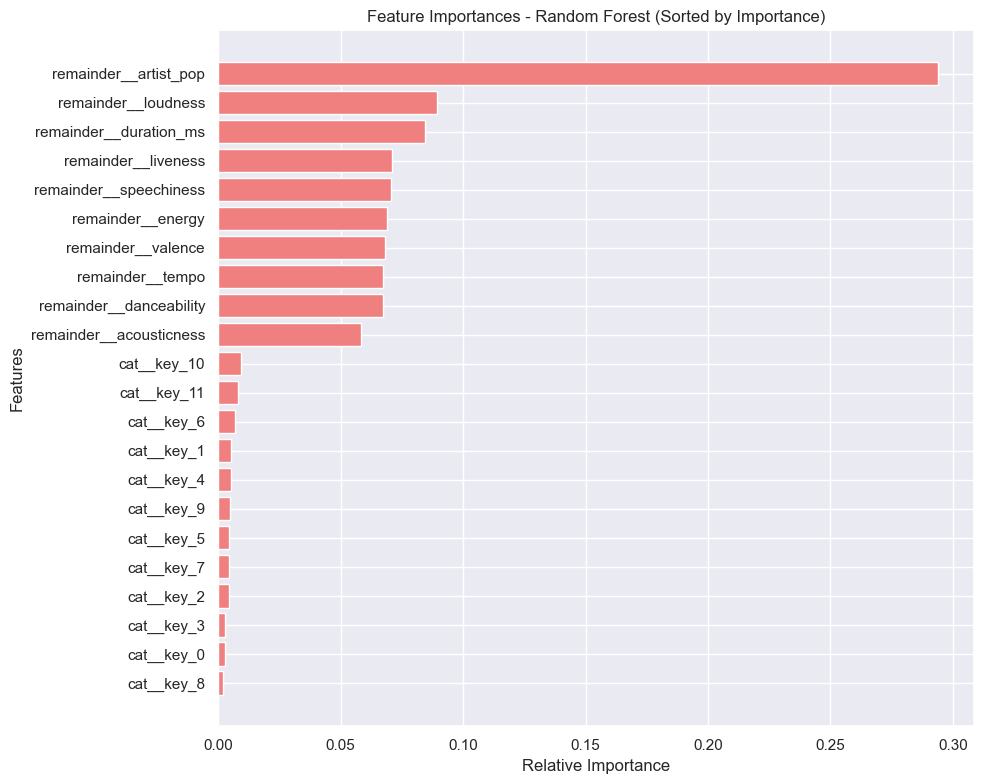

In [9]:
# Plot feature importances
importances_rf = rf_model.feature_importances_
sorted_indices_rf = np.argsort(importances_rf)  # Sort in ascending order for consistency
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices_rf)), importances_rf[sorted_indices_rf], align='center', color='lightcoral')
plt.yticks(range(len(sorted_indices_rf)), [X.columns[i] for i in sorted_indices_rf])
plt.title('Feature Importances - Random Forest (Sorted by Importance)')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Lasso Regression

In [10]:
# Separate features and the target 'track_pop'
features = predictors_df.drop('track_pop', axis=1)
target = predictors_df['track_pop']

# Define column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features.select_dtypes(include=['float64', 'int']).columns),
        ('cat', OneHotEncoder(), ['key'])
    ],
    remainder='passthrough'
)

# Create a Lasso regression pipeline
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.001, random_state=42))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the Lasso model
lasso_pipeline.fit(X_train, y_train)

# Predict on the test set
predictions = lasso_pipeline.predict(X_test)

# Calculate MSE and R-squared values
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Print out performance metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Access the trained ColumnTransformer from the pipeline
preprocessor = lasso_pipeline.named_steps['preprocessor']
numeric_features = features.select_dtypes(include=['float64', 'int']).columns.tolist()
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()

# Combine feature names from numeric and categorical transformations
all_feature_names = np.concatenate([numeric_features, categorical_features])

# Access the trained Lasso model
lasso_model = lasso_pipeline.named_steps['regressor']

# Get coefficients
coefficients = lasso_model.coef_

# Pair feature names with coefficients
feature_importance = pd.DataFrame({'Feature': all_feature_names, 'Coefficient': coefficients})
feature_importance = feature_importance.loc[coefficients != 0]  # Filter out zero coefficients for clarity

# Sort by the absolute values of the coefficients to identify the most important features
feature_importance = feature_importance.reindex(feature_importance['Coefficient'].abs().sort_values(ascending=False).index)

# Print feature importance
print(feature_importance)

Mean Squared Error (MSE): 357.4266
R-squared (R2): 0.2106
         Feature  Coefficient
0     artist_pop     9.537751
15         key_4     5.057478
14         key_3     3.701085
3       loudness     3.406970
20         key_9    -2.872451
19         key_8     2.382620
1   danceability    -2.363077
12         key_1    -2.053881
5    speechiness    -1.809063
16         key_5    -1.434159
4            key    -1.218307
10   duration_ms     1.107070
21        key_10     0.872404
2         energy    -0.811106
18         key_7    -0.702775
6   acousticness    -0.598627
7       liveness    -0.563089
8        valence     0.561090
17         key_6    -0.464360
9          tempo     0.351562
11         key_0     0.087030


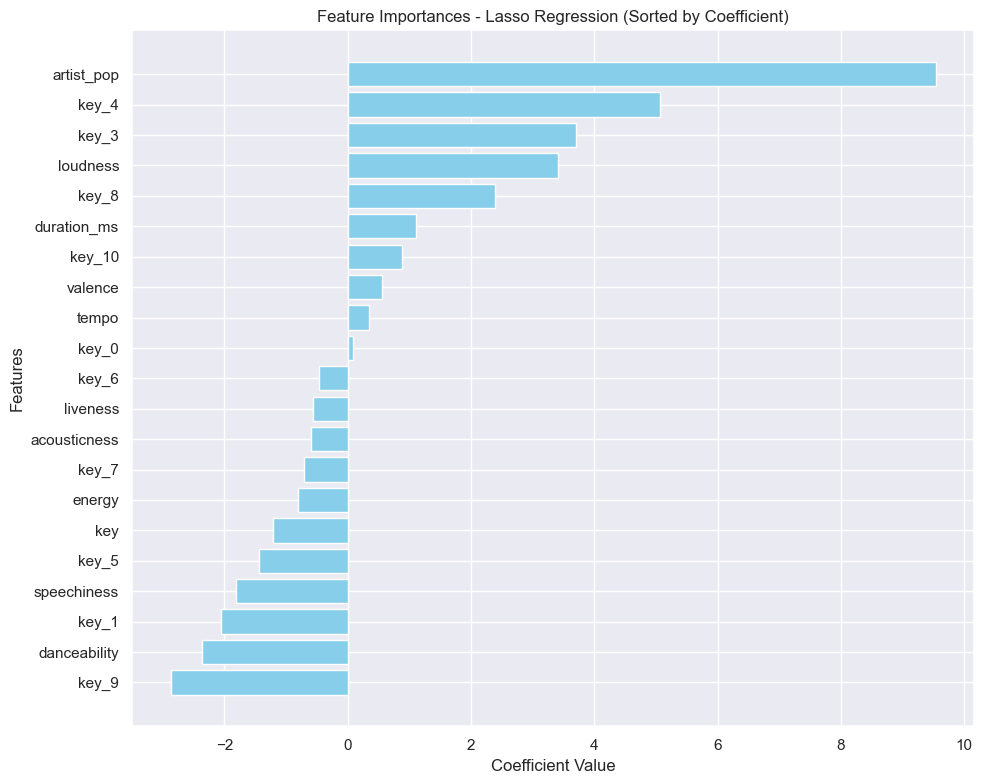

In [11]:
# Plot feature importances for Lasso Regression
feature_importance_sorted = feature_importance.sort_values(by='Coefficient', ascending=True)  # Sort in ascending order
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_sorted['Feature'], feature_importance_sorted['Coefficient'], color='skyblue')
plt.title('Feature Importances - Lasso Regression (Sorted by Coefficient)')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# H2O AUTOML for dataset with "artist_pop"

In [12]:
import h2o
from h2o.automl import H2OAutoML

In [13]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "21.0.2" 2024-01-16 LTS; Java(TM) SE Runtime Environment (build 21.0.2+13-LTS-58); Java HotSpot(TM) 64-Bit Server VM (build 21.0.2+13-LTS-58, mixed mode, sharing)
  Starting server from /Users/weiyew/anaconda3/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/tmpq3ja1vzy
  JVM stdout: /var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/tmpq3ja1vzy/h2o_weiyew_started_from_python.out
  JVM stderr: /var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/tmpq3ja1vzy/h2o_weiyew_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Singapore
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.1
H2O_cluster_version_age:    1 month and 11 days
H2O_cluster_name:           H2O_from_python_weiyew_z5fe2h
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.984 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.5 final
--------------------------  -----------------------------

In [14]:
# Load data as H2OFrame
hf = h2o.H2OFrame(predictors_df)

# Specify the target variable and input features
target = "track_pop"
features = [col for col in hf.columns if col != target]

# Split the data into training and testing sets within H2O
train, test = hf.split_frame(ratios=[.8], seed=42)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# Configure and run H2O AutoML
aml = H2OAutoML(
    max_models=10,
    seed=10,
    exclude_algos=["DeepLearning", "StackedEnsemble"],  
    project_name="track_popularity_project"
)

In [16]:
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |
19:20:39.296: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20240424_192039


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    28                 28                          13644                  8            8            8             20            47            34.1429

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 184.6054872103477
RMSE: 13.586960190209865
MAE: 9.346622115030339
RMSLE: 0.9631792833802549
Mean Residual Deviance: 184.6054872103477

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 444.9080142112325
RMSE: 21.092842724754586
MAE: 14.59430668778229
RMSLE: 1.1116424698963687
Mean Residual Deviance: 444.9080142112325

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
aic                     nan       0          nan           nan           nan           nan           nan
loglikelihood           nan       0          nan           nan           nan           nan           nan
mae                     14.6898   0.512638   14.6807       15.2449       14.3717       15.1309       14.0211
mean_residual_deviance  453.678   40.4725    473.395       509.555       451.617       429.822       404.002
mse                     453.678   40.4725    473.395       509.555       451.617       429.822       404.002
r2                      0.209979  0.0773148  0.186575      0.113477      0.277391      0.172476      0.299974
residual_deviance       453.678   40.4725    473.395       509.555       451.617       429.822       404.002
rmse                    21.2828   0.947977   21.7576       22.5733       21.2513       20.7322       20.0998
rmsle                   1.10505   0.136503   1.06984       1.20998       1.26627       0.9202        1.05897

Scoring History: 
    timestamp            duration    number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------  -----------------  ---------------  --------------  -------------------
    2024-04-24 19:20:40  0.094 sec   0                  24.0199          18.2052         576.957
    2024-04-24 19:20:40  0.102 sec   5                  20.2605          14.7451         410.487
    2024-04-24 19:20:40  0.110 sec   10                 18.0186          12.7637         324.67
    2024-04-24 19:20:40  0.118 sec   15                 16.1482          11.2604         260.766
    2024-04-24 19:20:40  0.126 sec   20                 14.911           10.3305         222.339
    2024-04-24 19:20:40  0.134 sec   25                 14.0636          9.67498         197.785
    2024-04-24 19:20:40  0.138 sec   28                 13.587           9.34662         184.605

Variable Importances: 
variable      relative_importance    scaled_importance    percentage
------------  ---------------------  -------------------  ------------
artist_pop    456394                 1                    0.296955
duration_ms   167062                 0.366049             0.1087
valence       150935                 0.330713             0.098207
tempo         109643                 0.240237             0.0713397
loudness      109212                 0.239294             0.0710596
danceability  106355                 0.233034             0.0692007
speechiness   103953                 0.227771             0.0676379
energy        99073.9                0.21708              0.064463
liveness      92717                  0.203151             0.0603269
acousticness  83259.9                0.18243              0.0541735

In [17]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows

# Predict on the test data using the leader model
leader_model = aml.leader
predictions = leader_model.predict(test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [18]:
# Evaluate performance
performance = leader_model.model_performance(test)
performance

ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 414.54457493936775
RMSE: 20.360367750592516
MAE: 13.857485219310444
RMSLE: 1.1218684002475123
Mean Residual Deviance: 414.54457493936775

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                        rmse      mse      mae    rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
-------------------------------------------  -------  -------  -------  -------  ------------------------  ------------------  -------------------------  ------
DRF_1_AutoML_1_20240424_192039               19.4625  378.789  13.2486  1.08935                   378.789                 107                   0.007471  DRF
XRT_1_AutoML_1_20240424_192039               19.4959  380.089  13.0307  1.07944                   380.089                 131                   0.007327  DRF
GBM_4_AutoML_1_20240424_192039               19.9738  398.952  13.7204  1.10711                   398.952                  50                   0.003427  GBM
GBM_grid_1_AutoML_1_20240424_192039_model_2  20.1922  407.725  13.7004  1.10302                   407.725                  59                   0.003674  GBM
GBM_2_AutoML_1_20240424_192039               20.3316  413.373  14.2636  1.1245                    413.373                  40                   0.002744  GBM
GBM_3_AutoML_1_20240424_192039               20.3604  414.545  13.8575  1.12187                   414.545                  45                   0.00301   GBM
GBM_5_AutoML_1_20240424_192039               20.4277  417.293  14.166   1.09437                   417.293                  48                   0.002869  GBM
GBM_1_AutoML_1_20240424_192039               20.7959  432.471  14.6059  1.14863                   432.471                  50                   0.002453  GBM
GLM_1_AutoML_1_20240424_192039               20.9294  438.039  14.3782  1.1513                    438.039                  10                   0.002815  GLM
GBM_grid_1_AutoML_1_20240424_192039_model_1  21.0378  442.587  15.0641  1.14982                   442.587                  23                   0.003941  GBM
[10 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

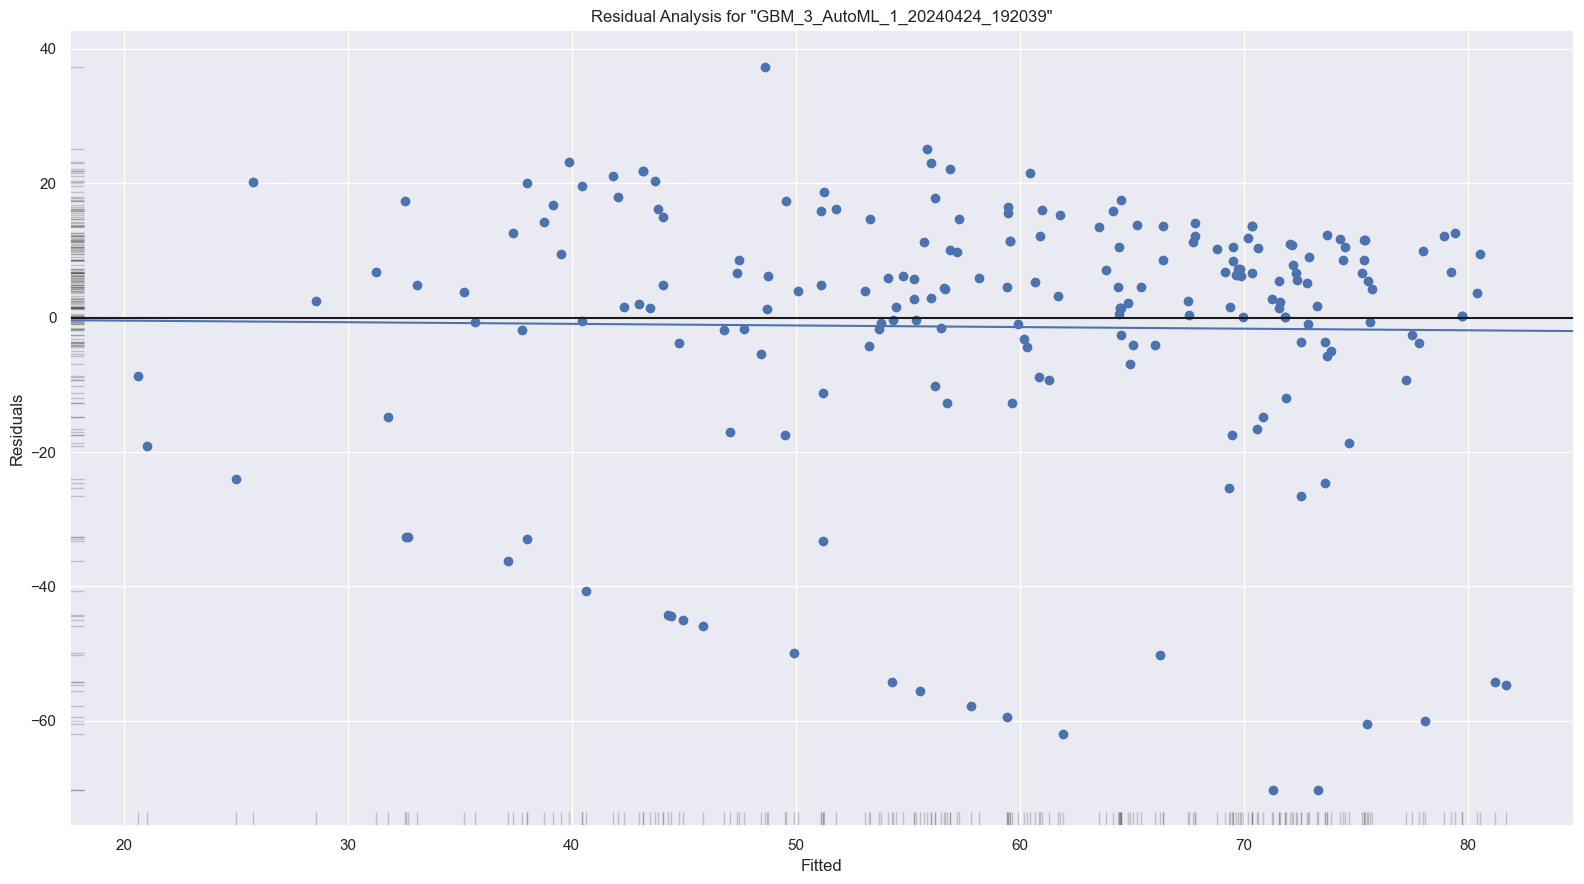

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

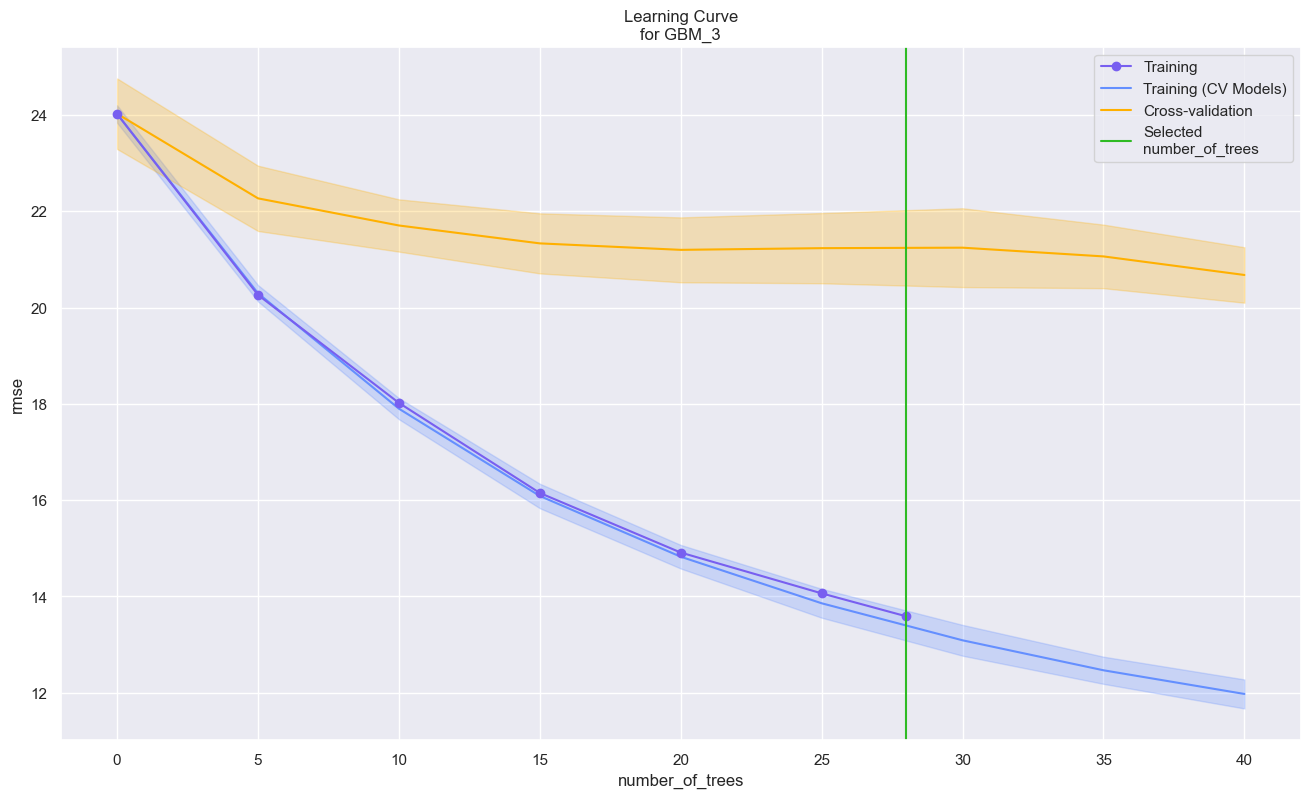

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

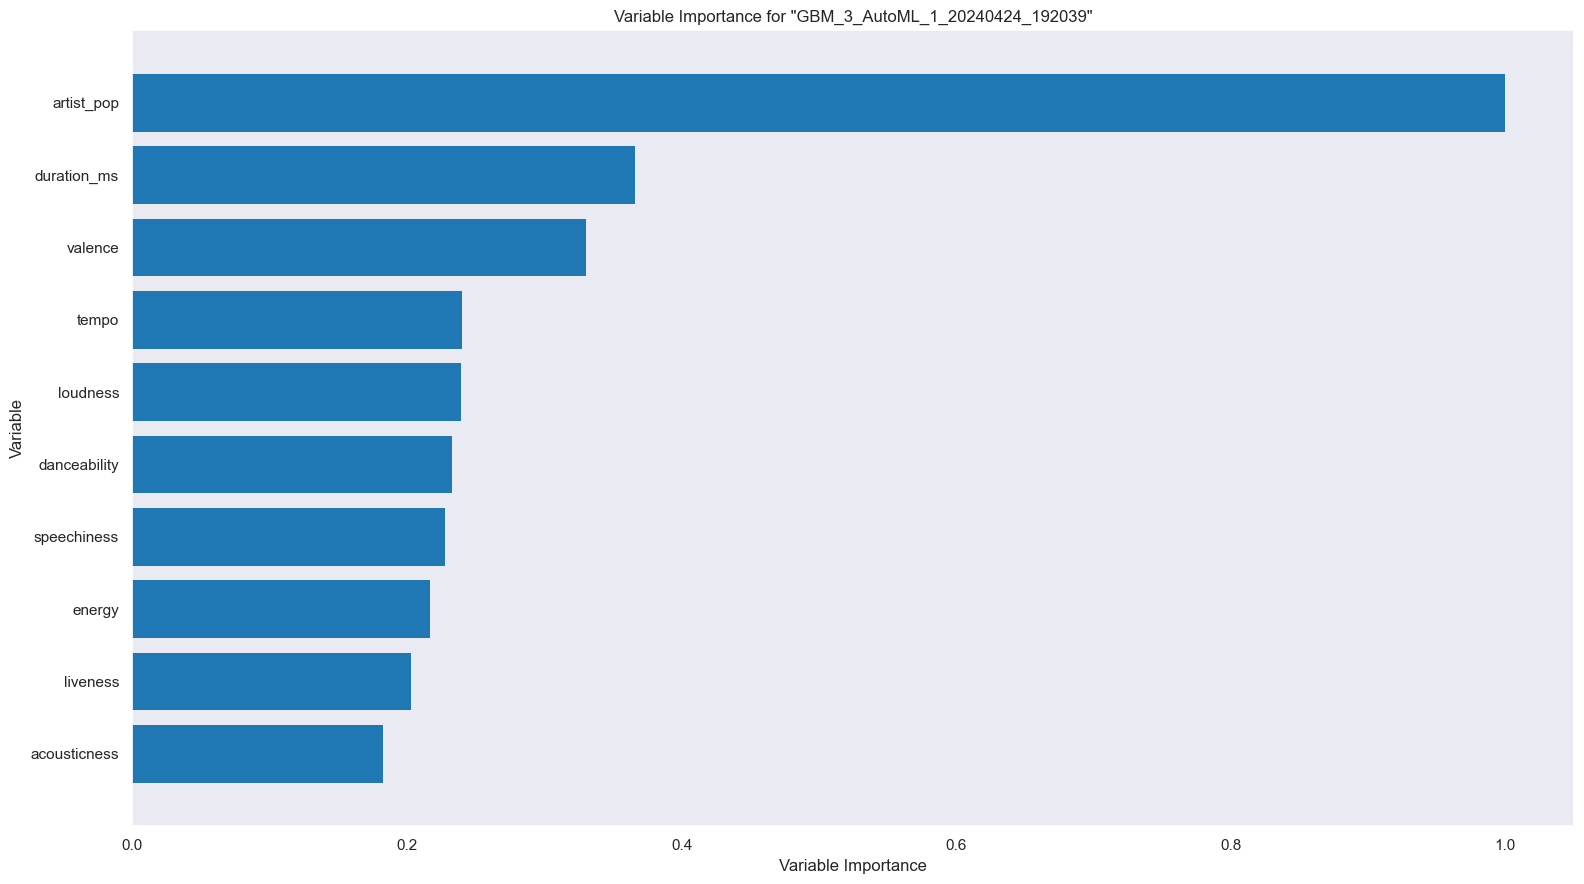

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

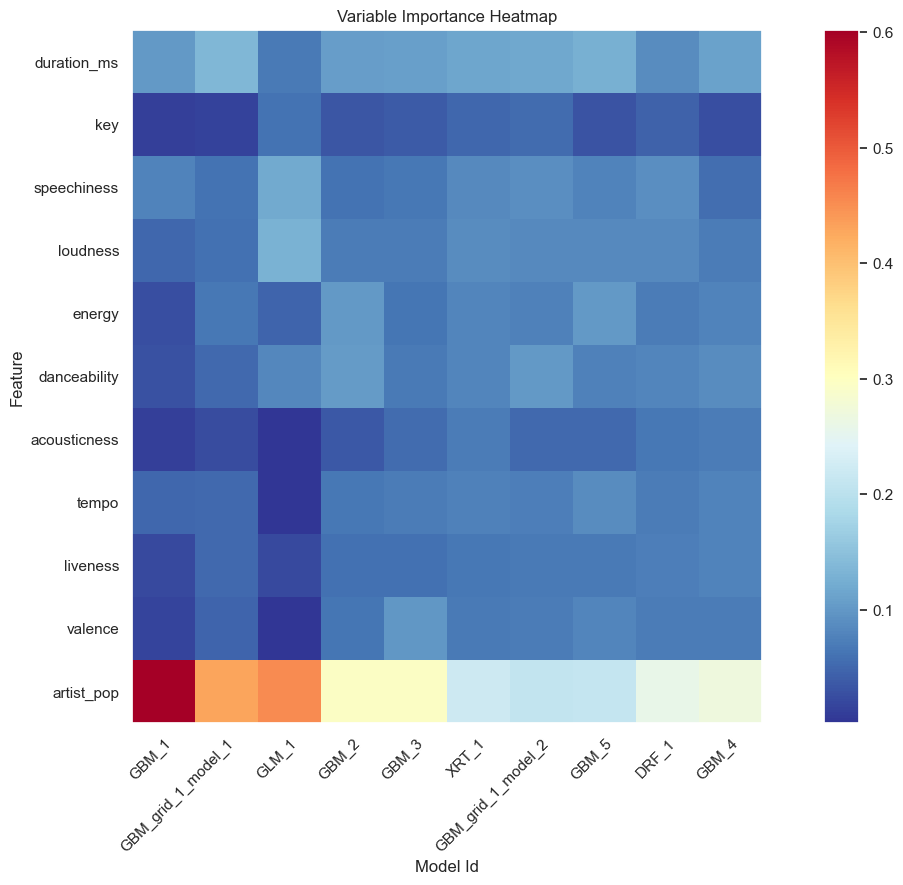

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

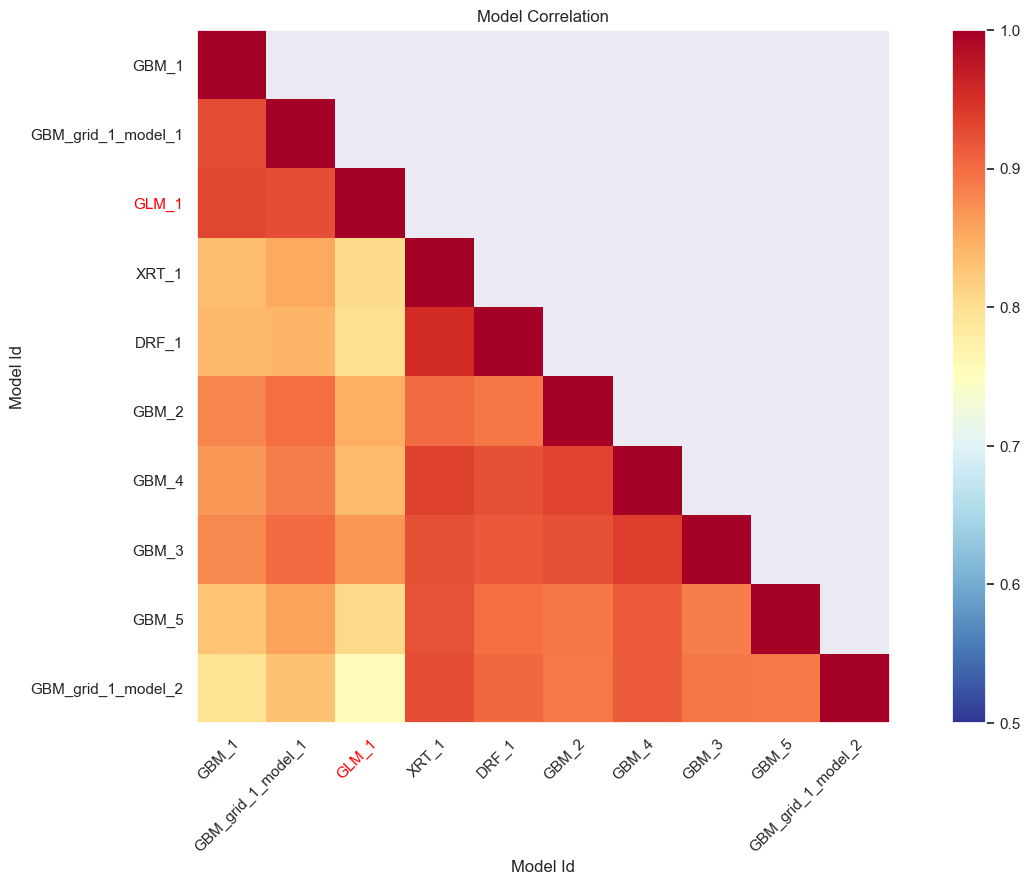

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

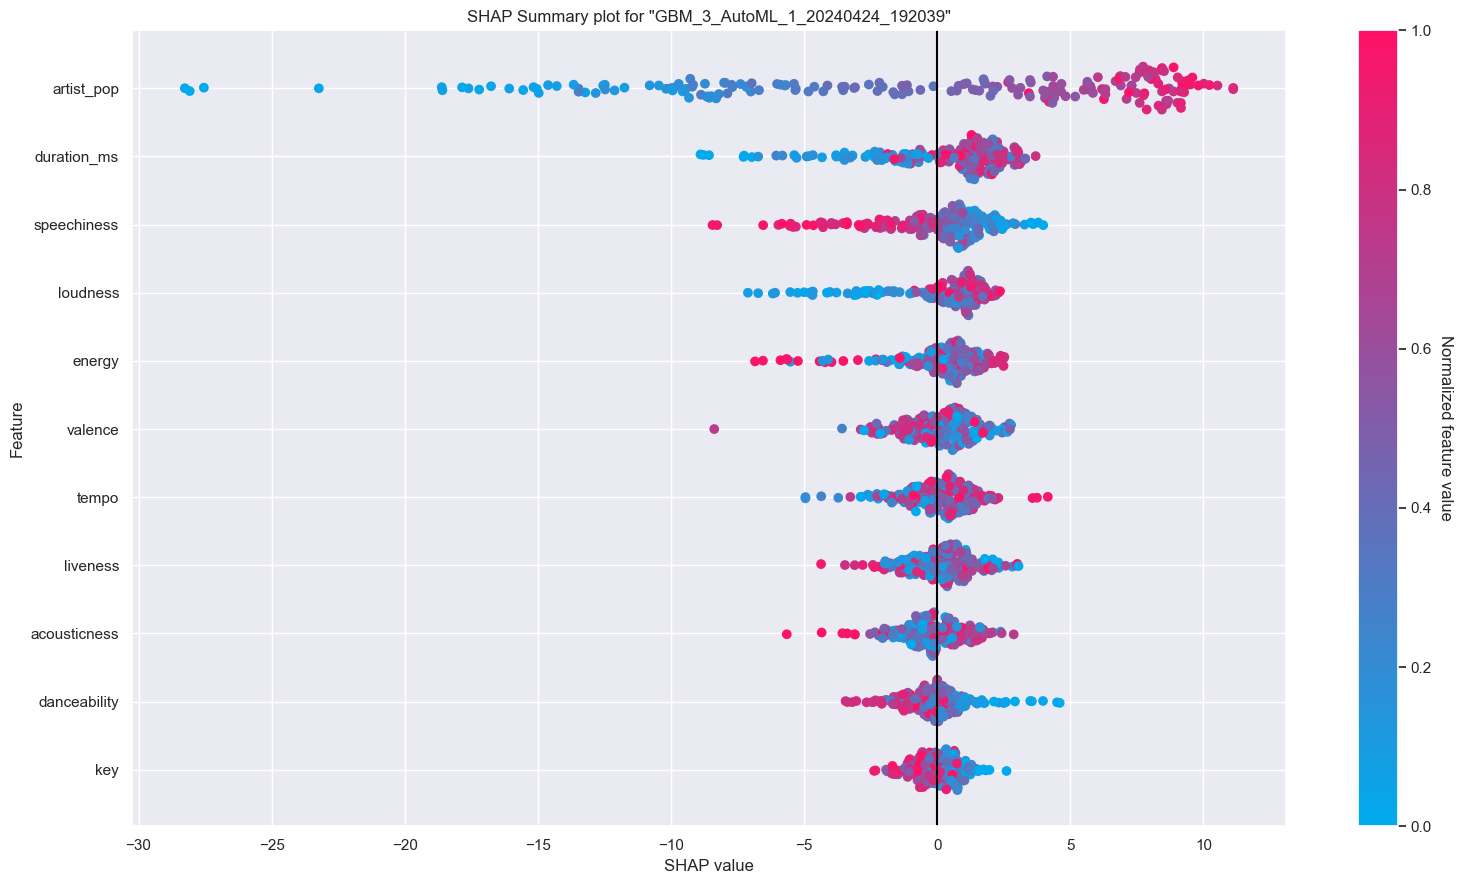

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

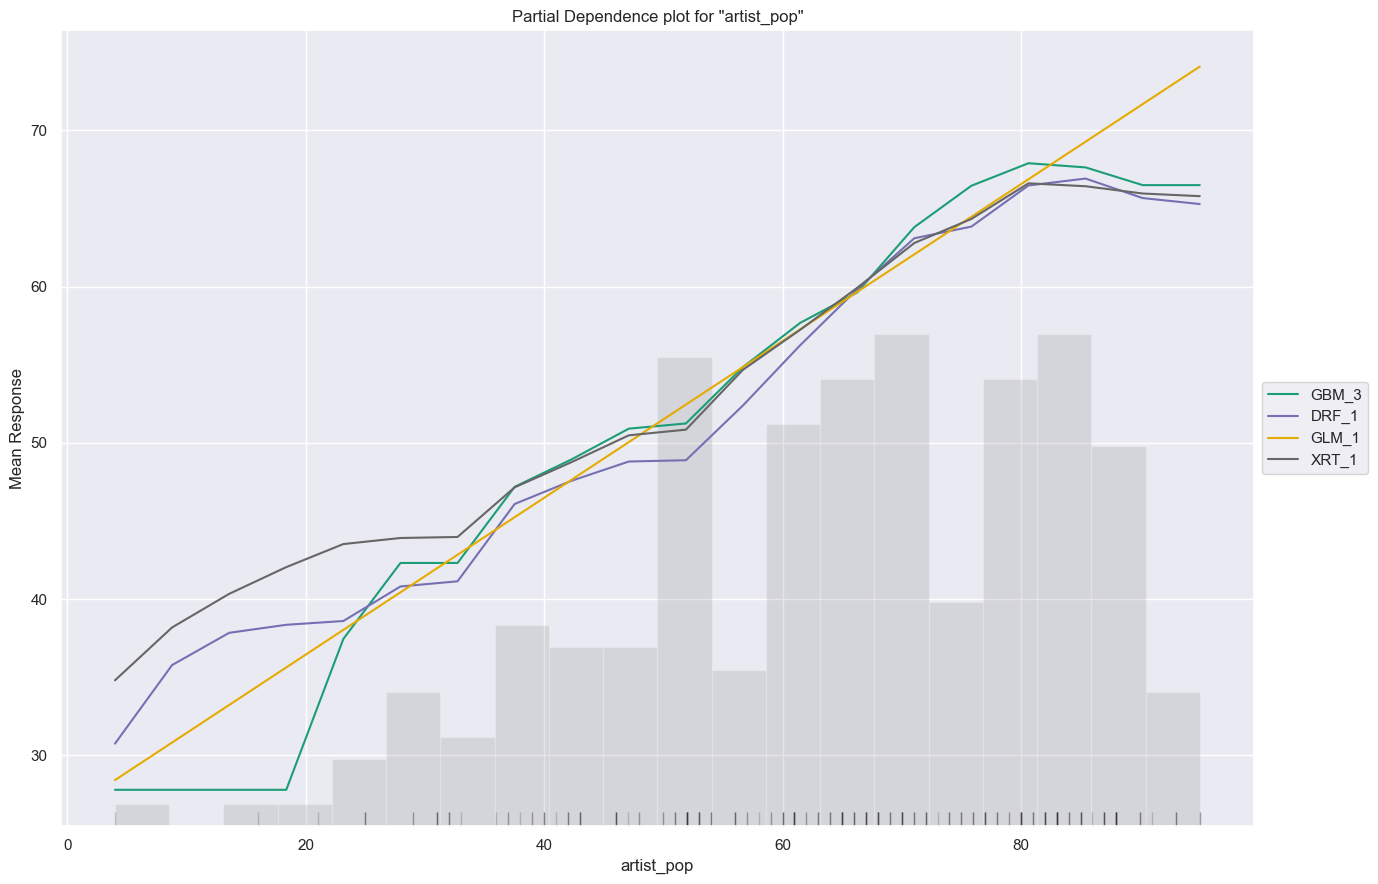

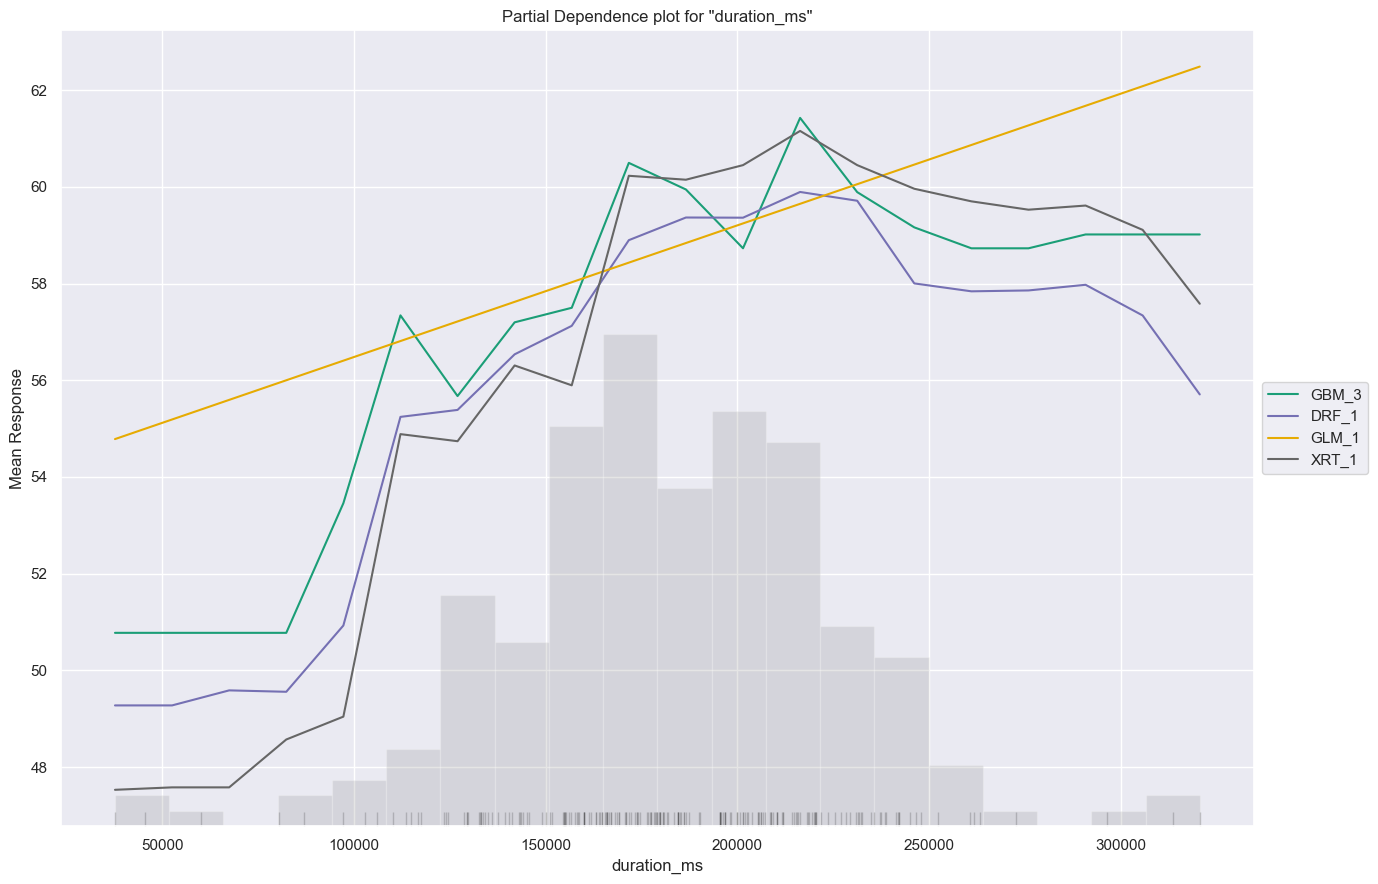

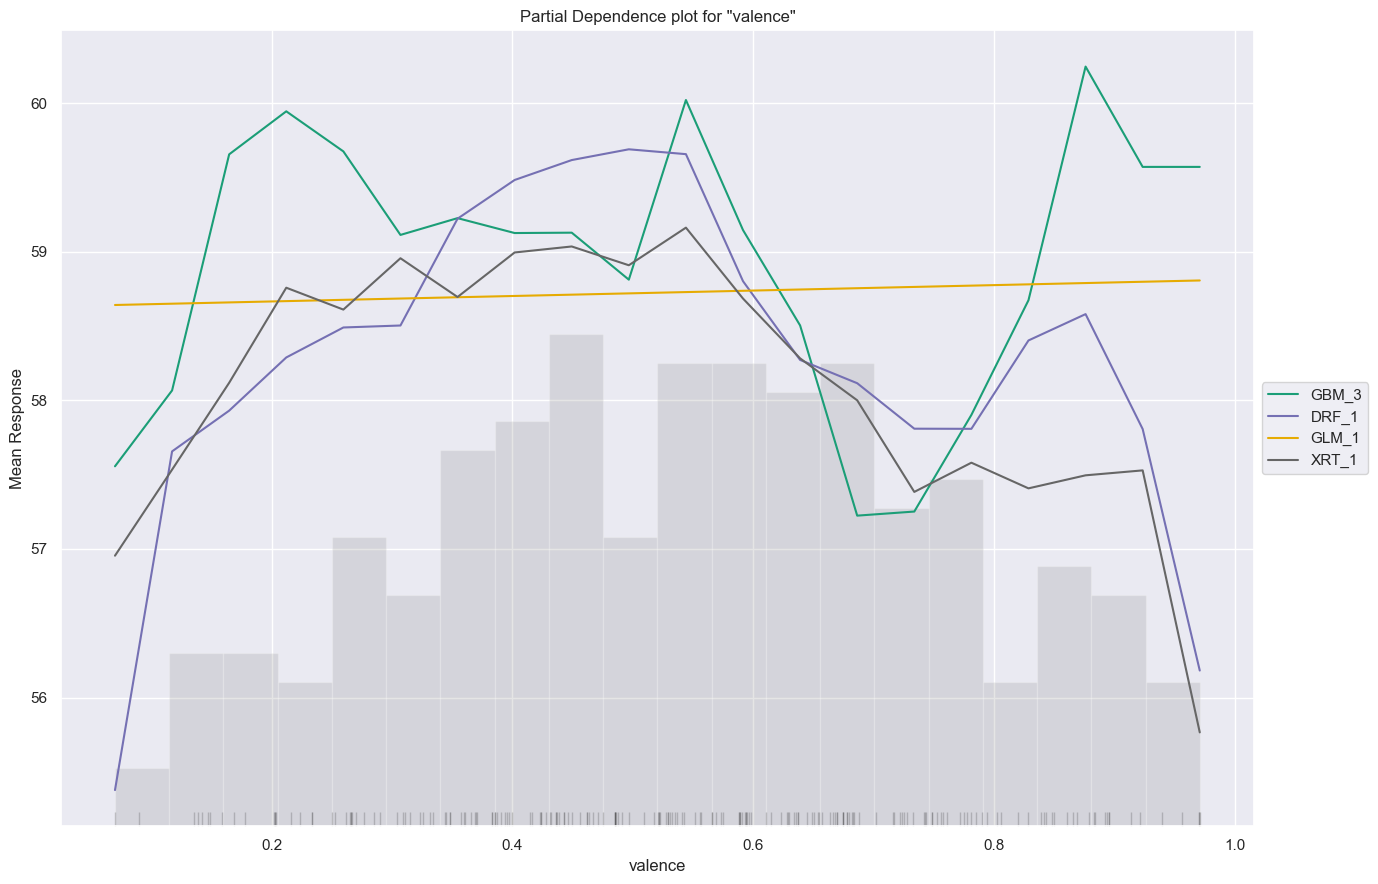

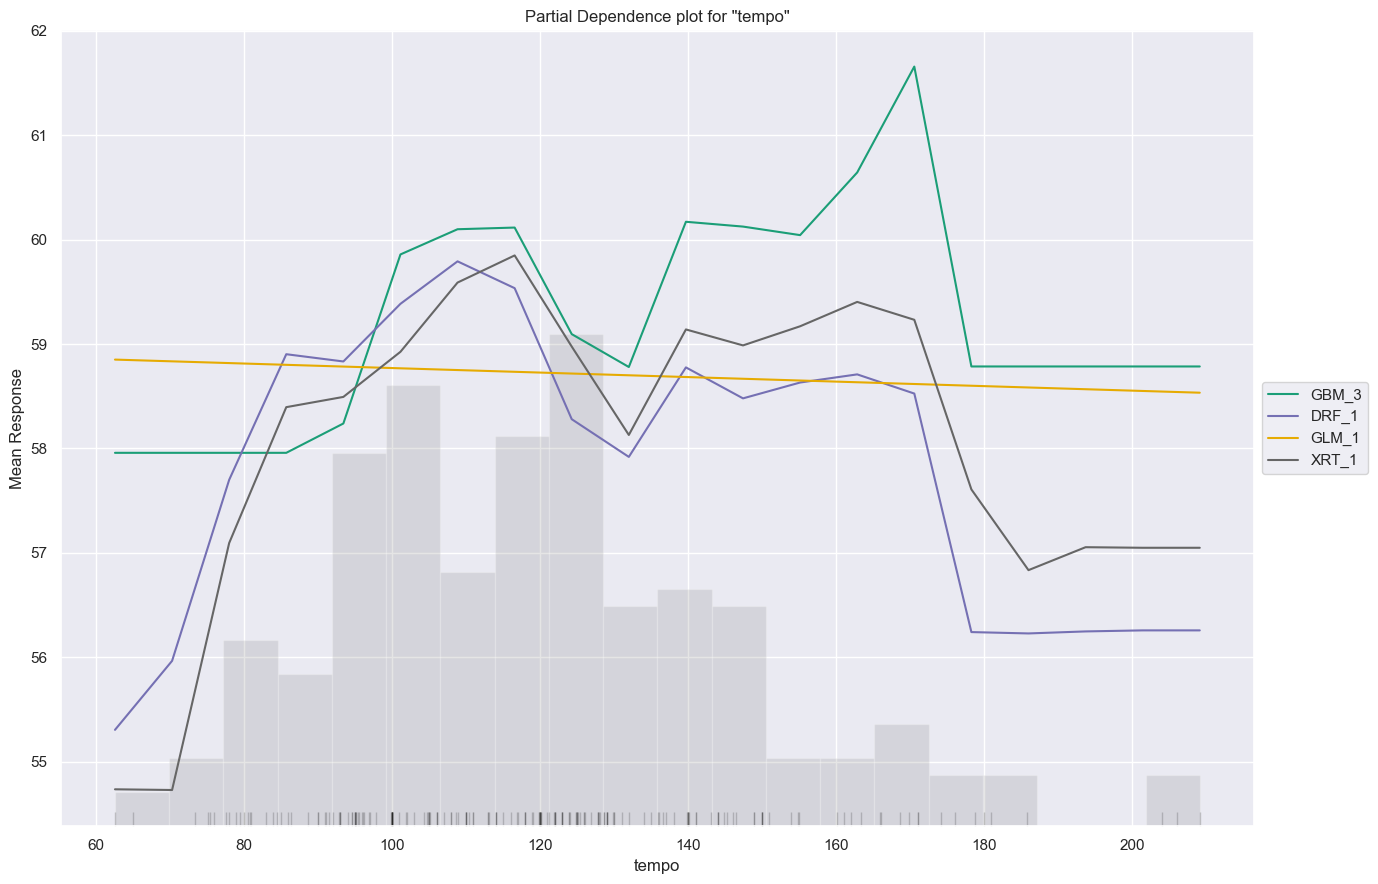

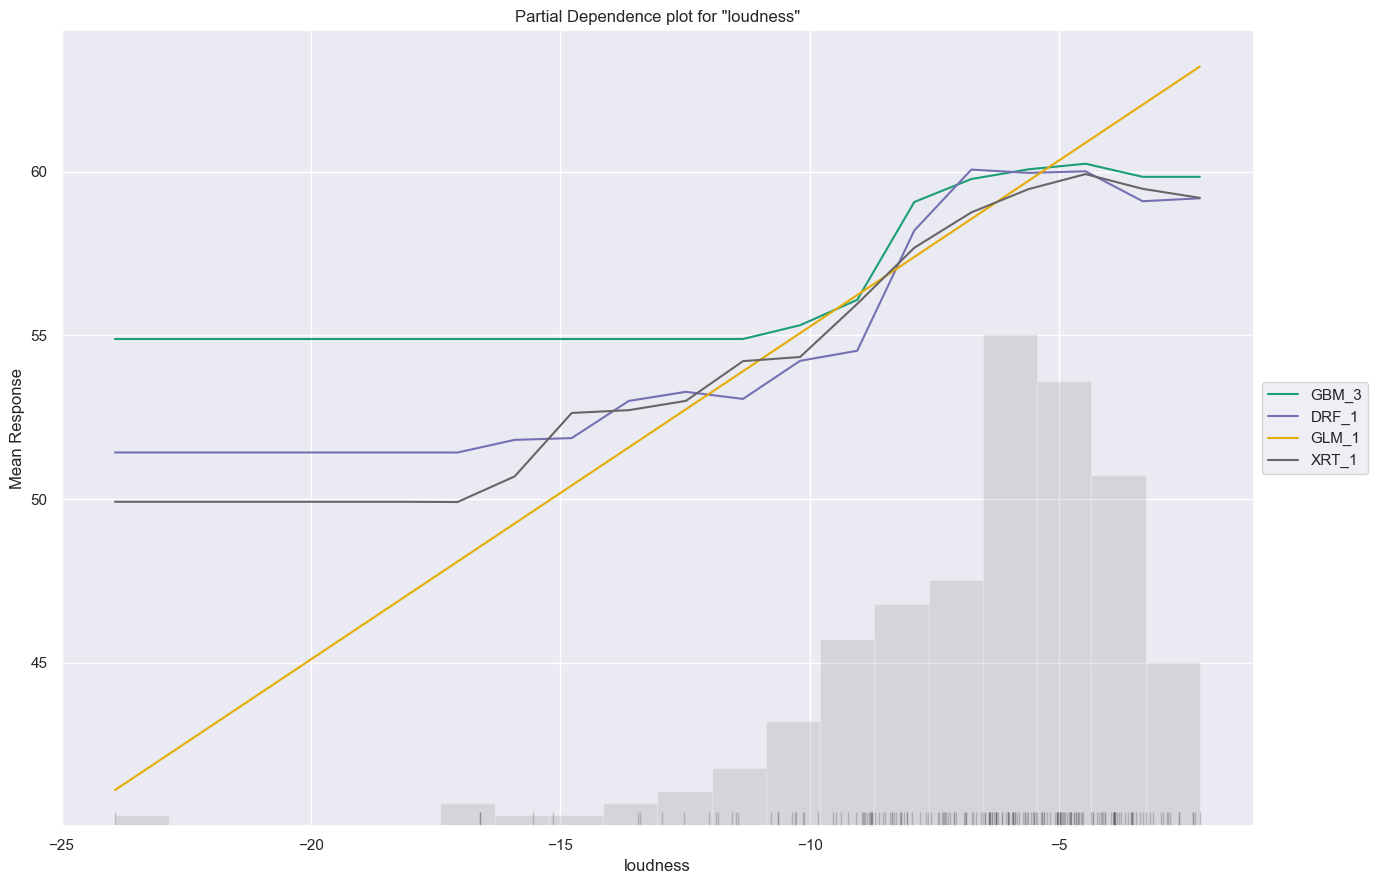

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

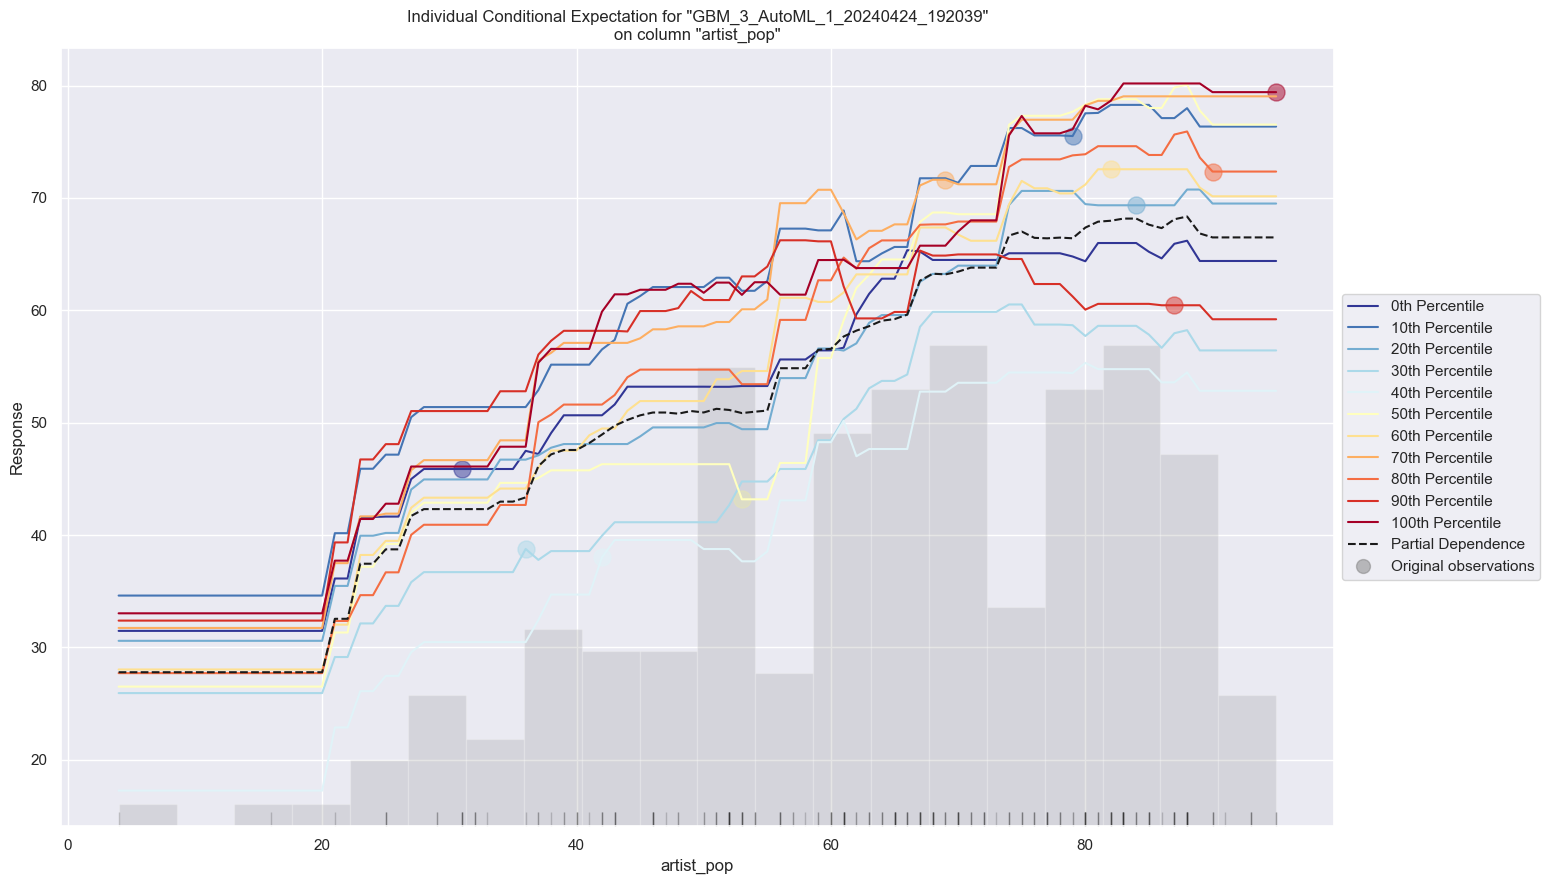

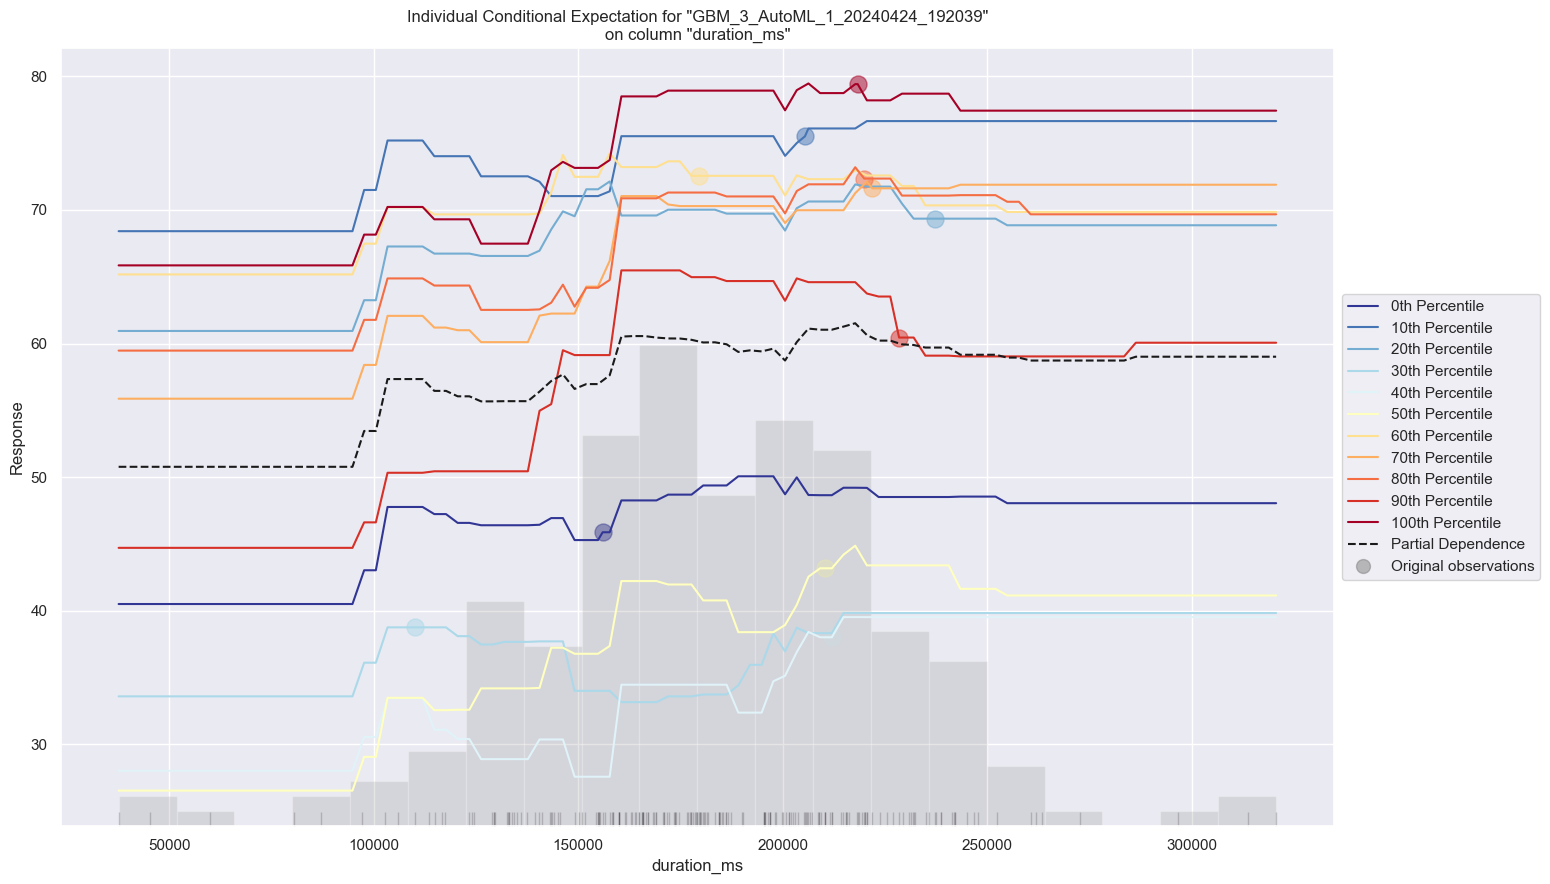

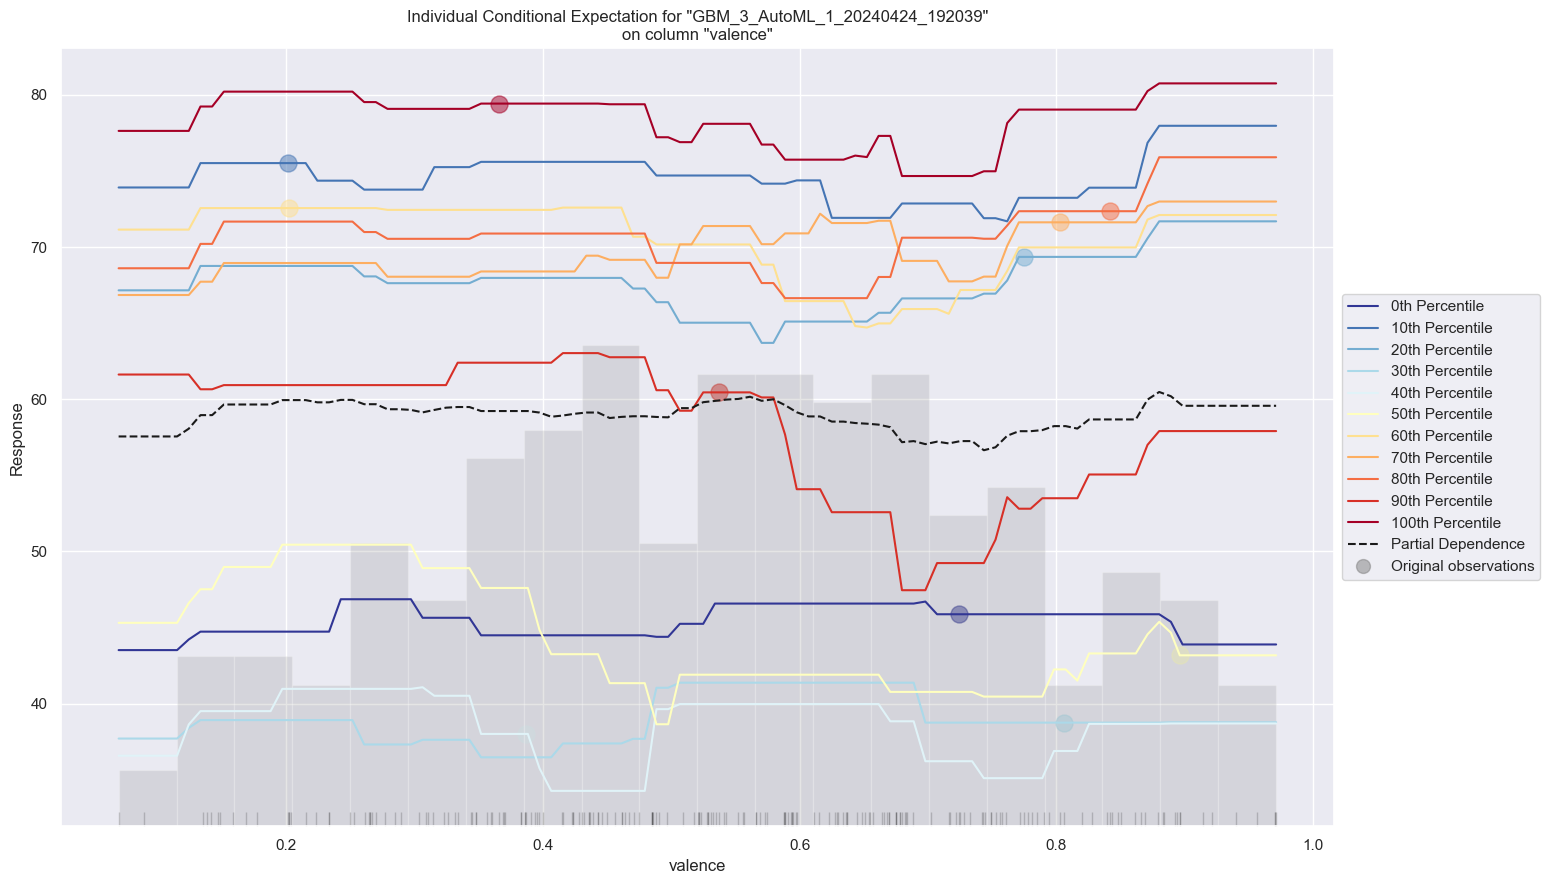

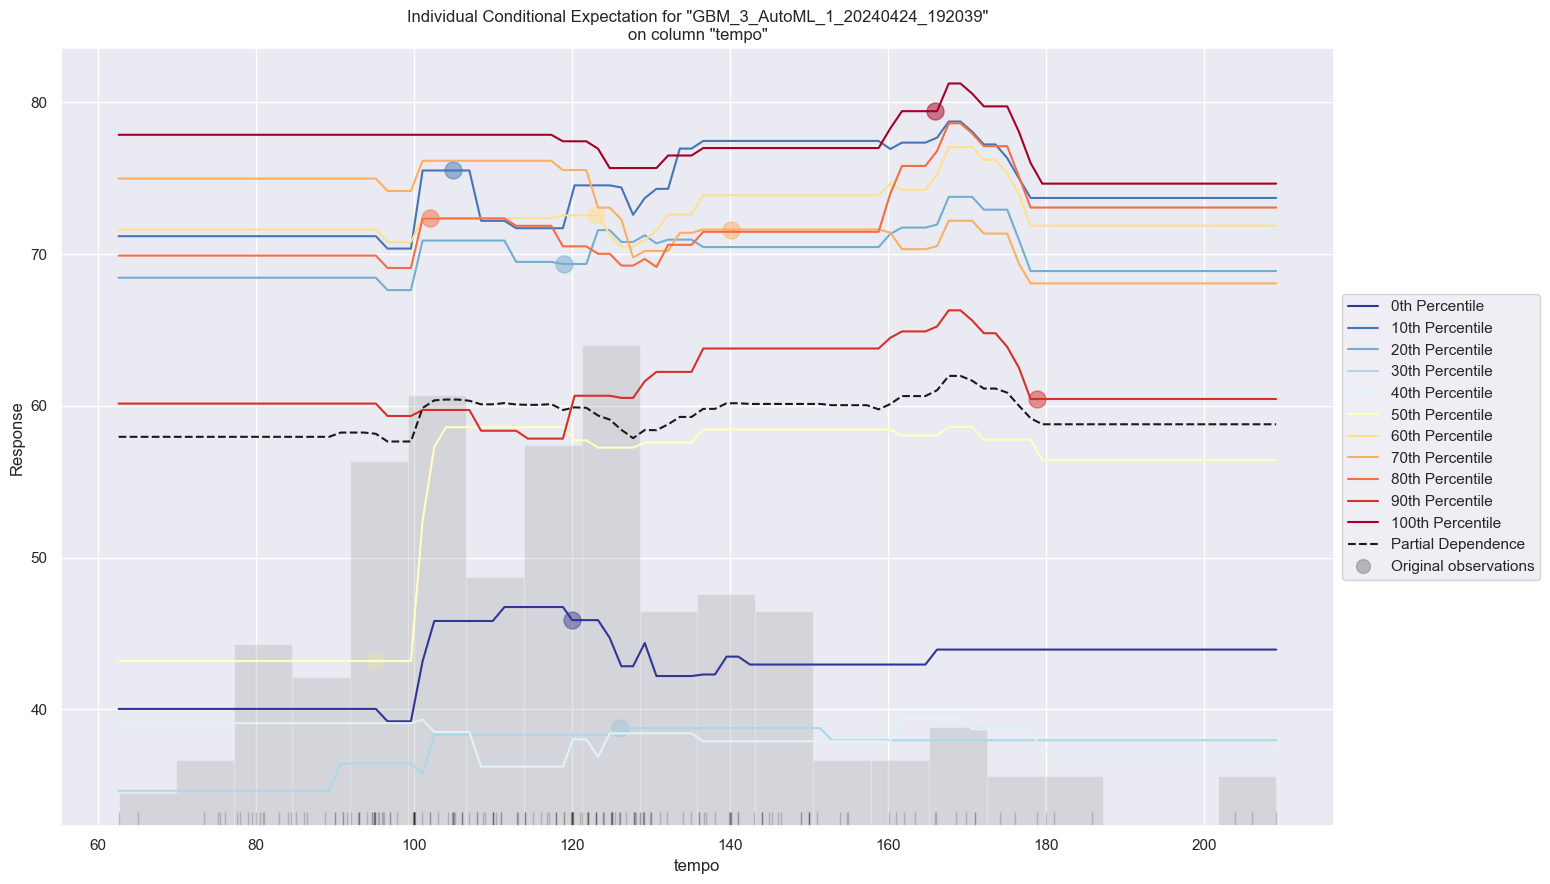

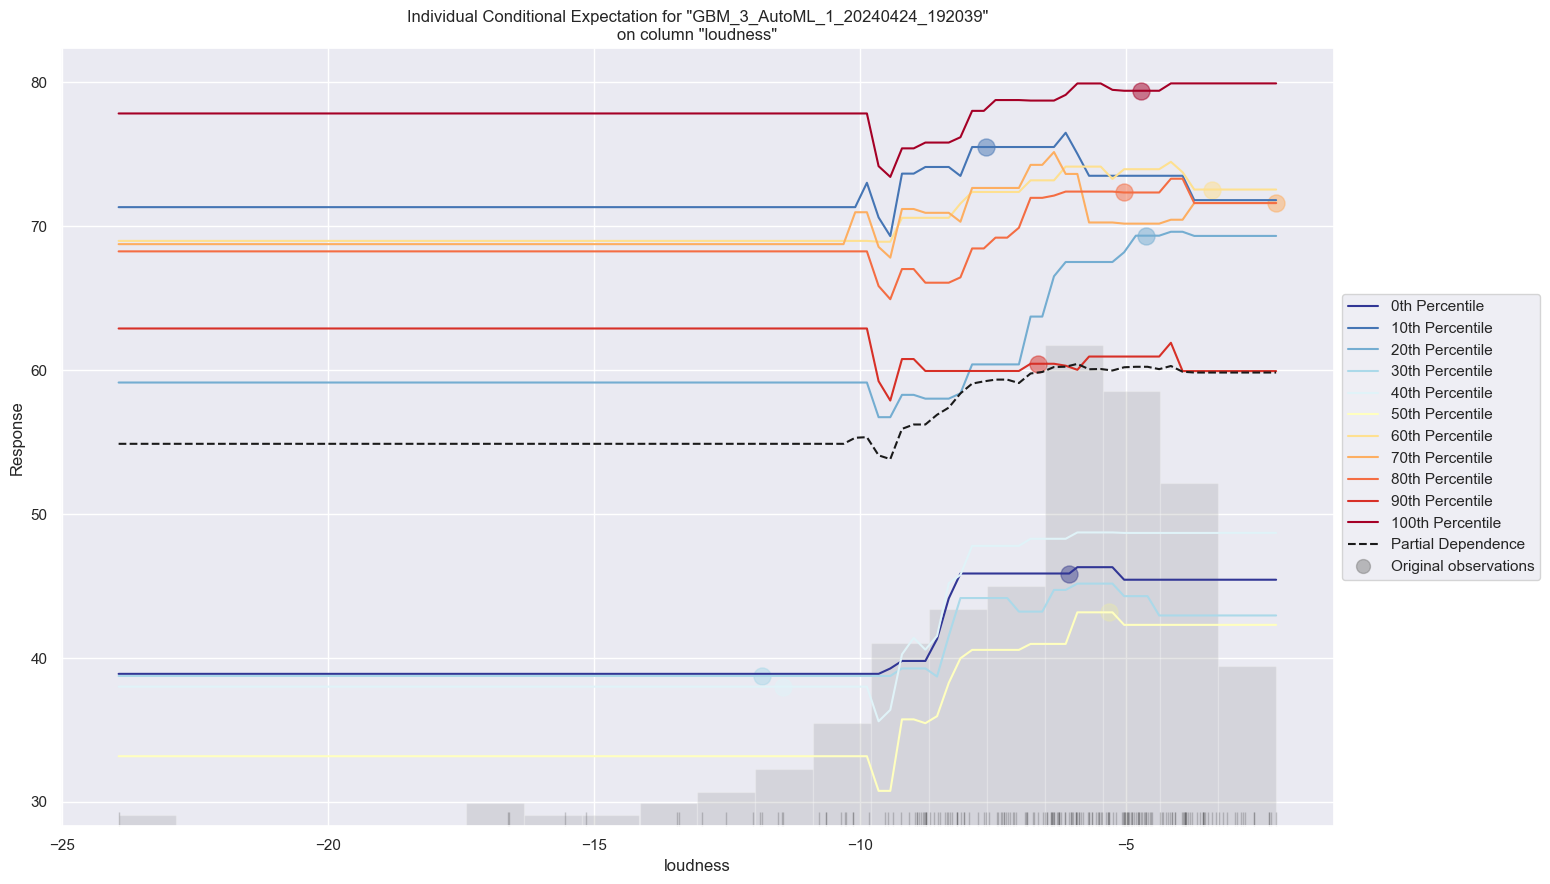

In [19]:
exa = aml.explain(test)


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

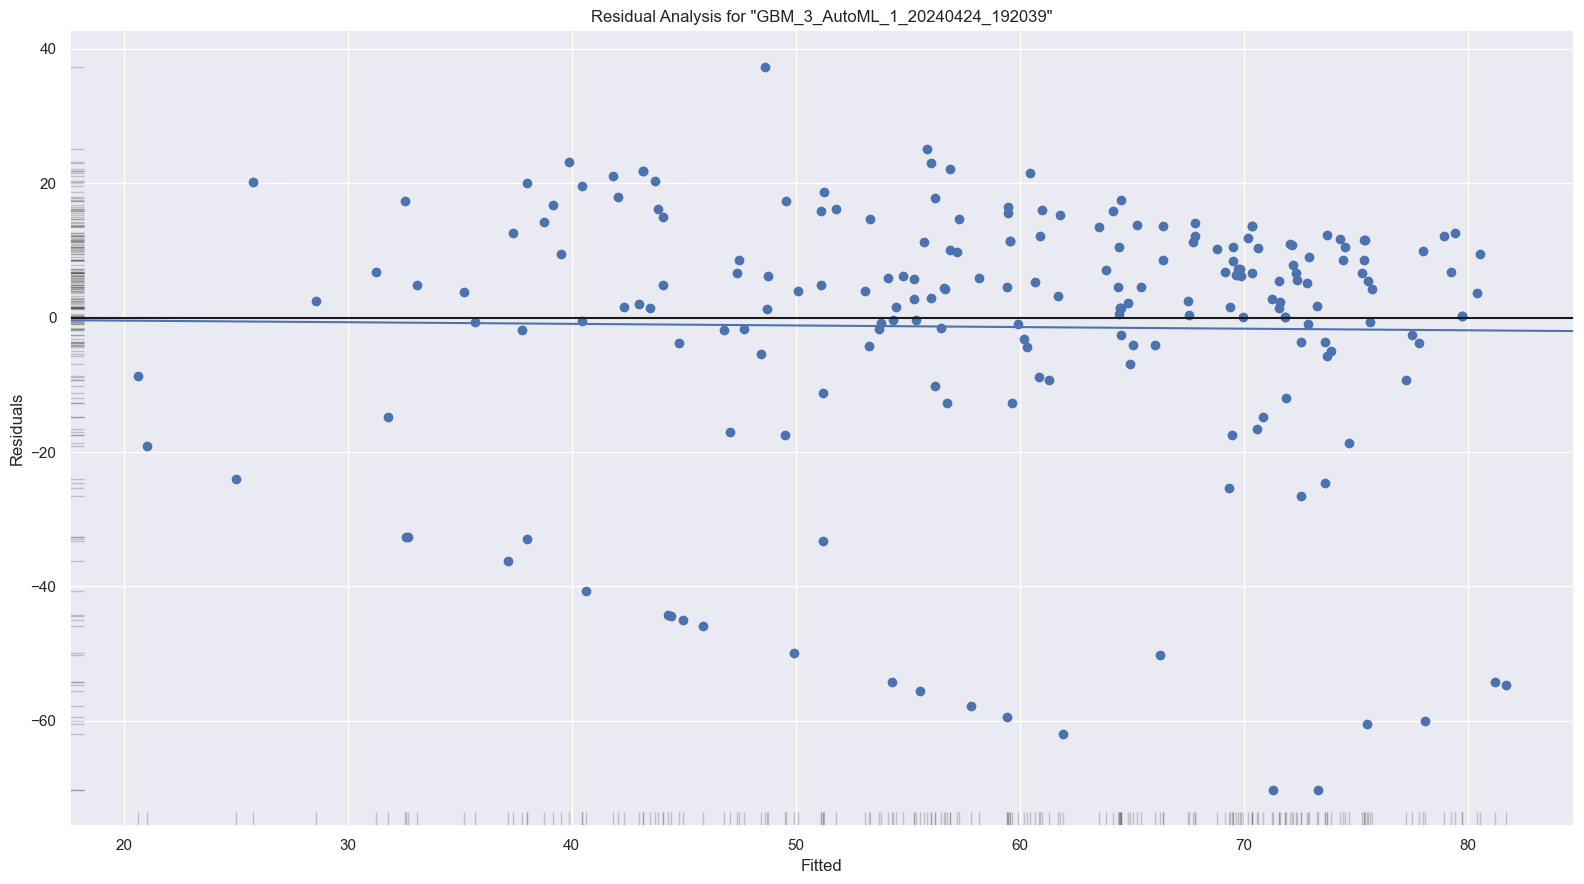

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

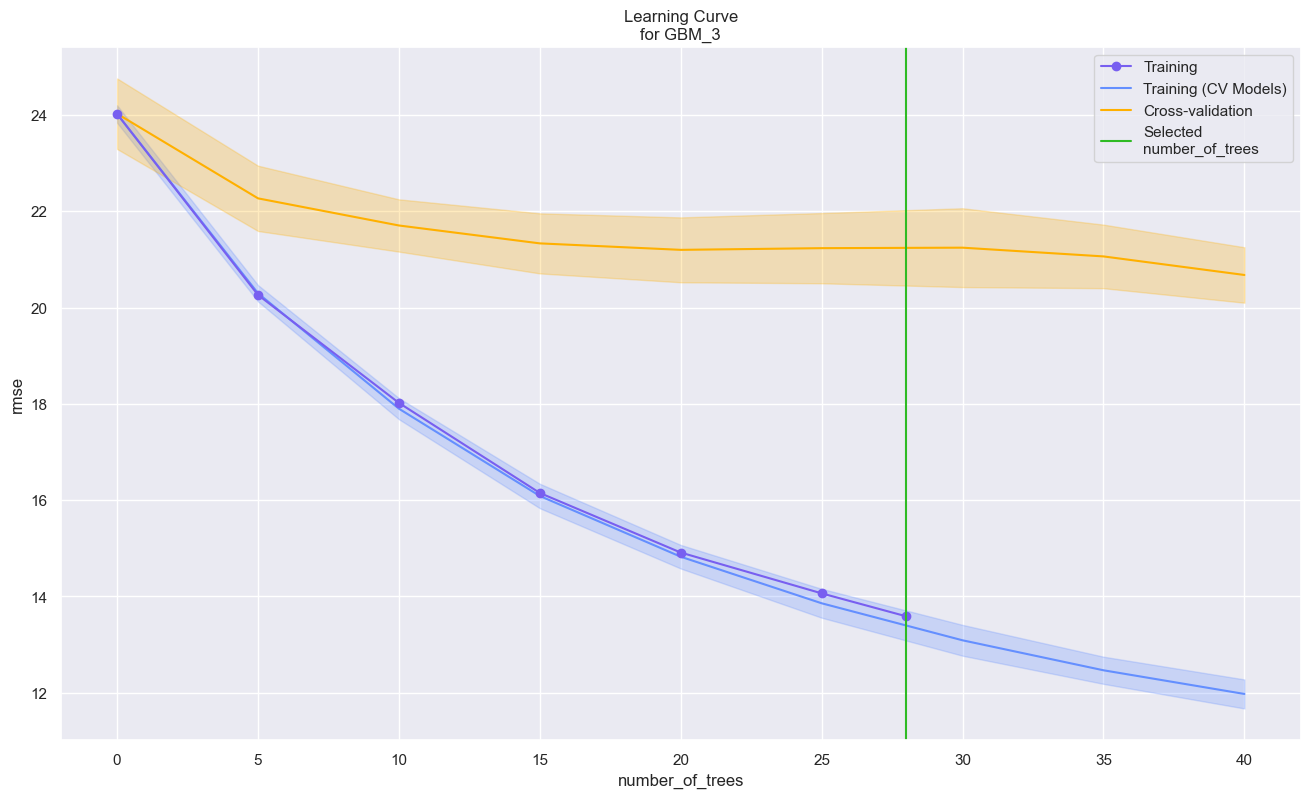

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

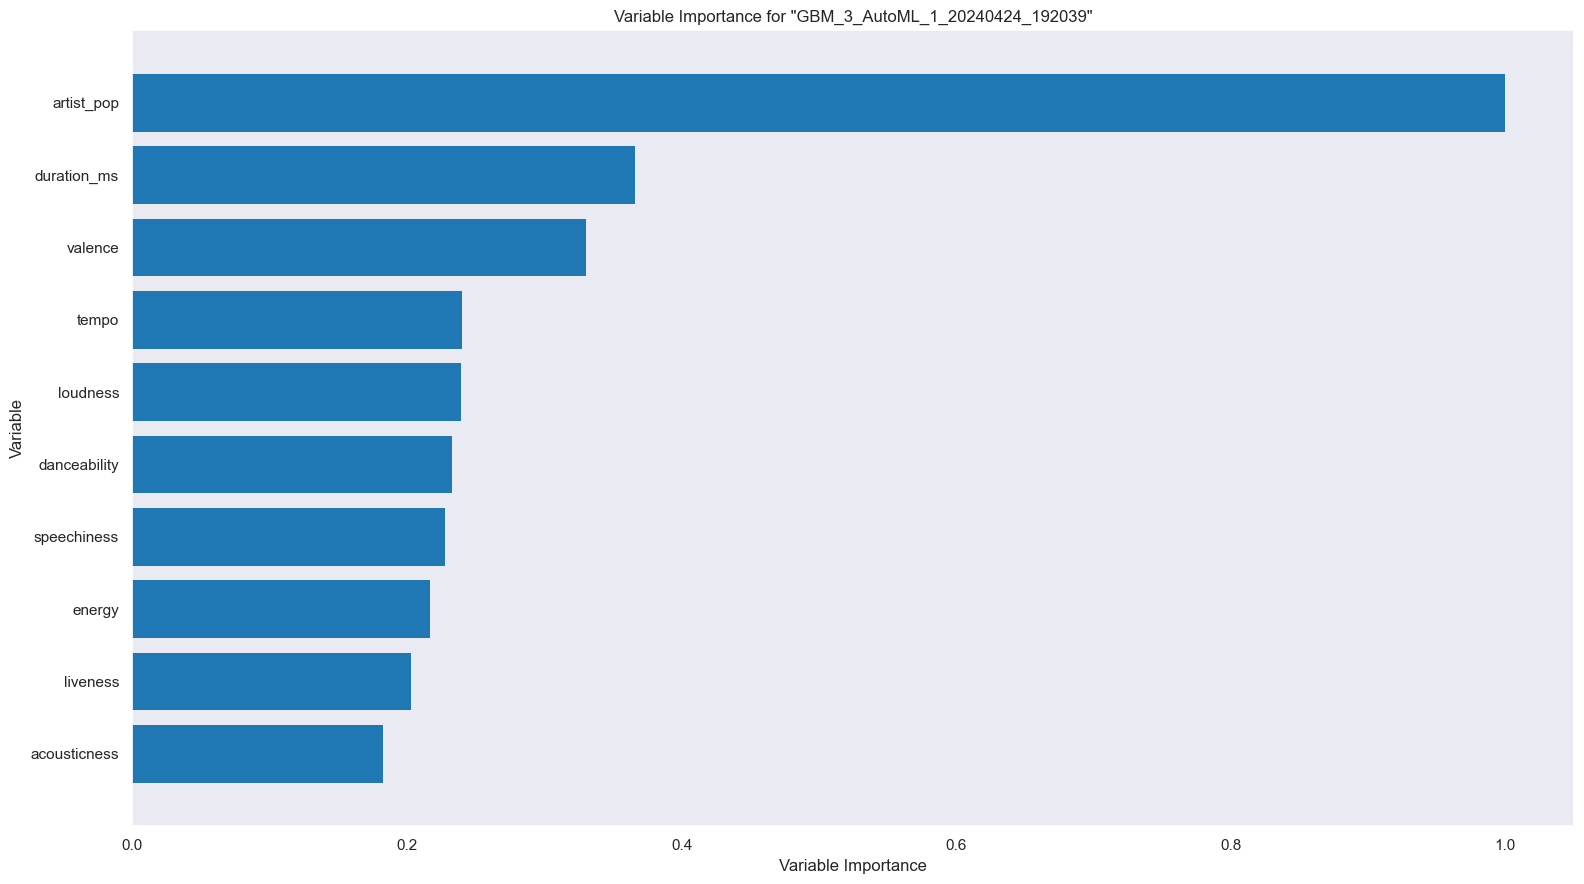

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

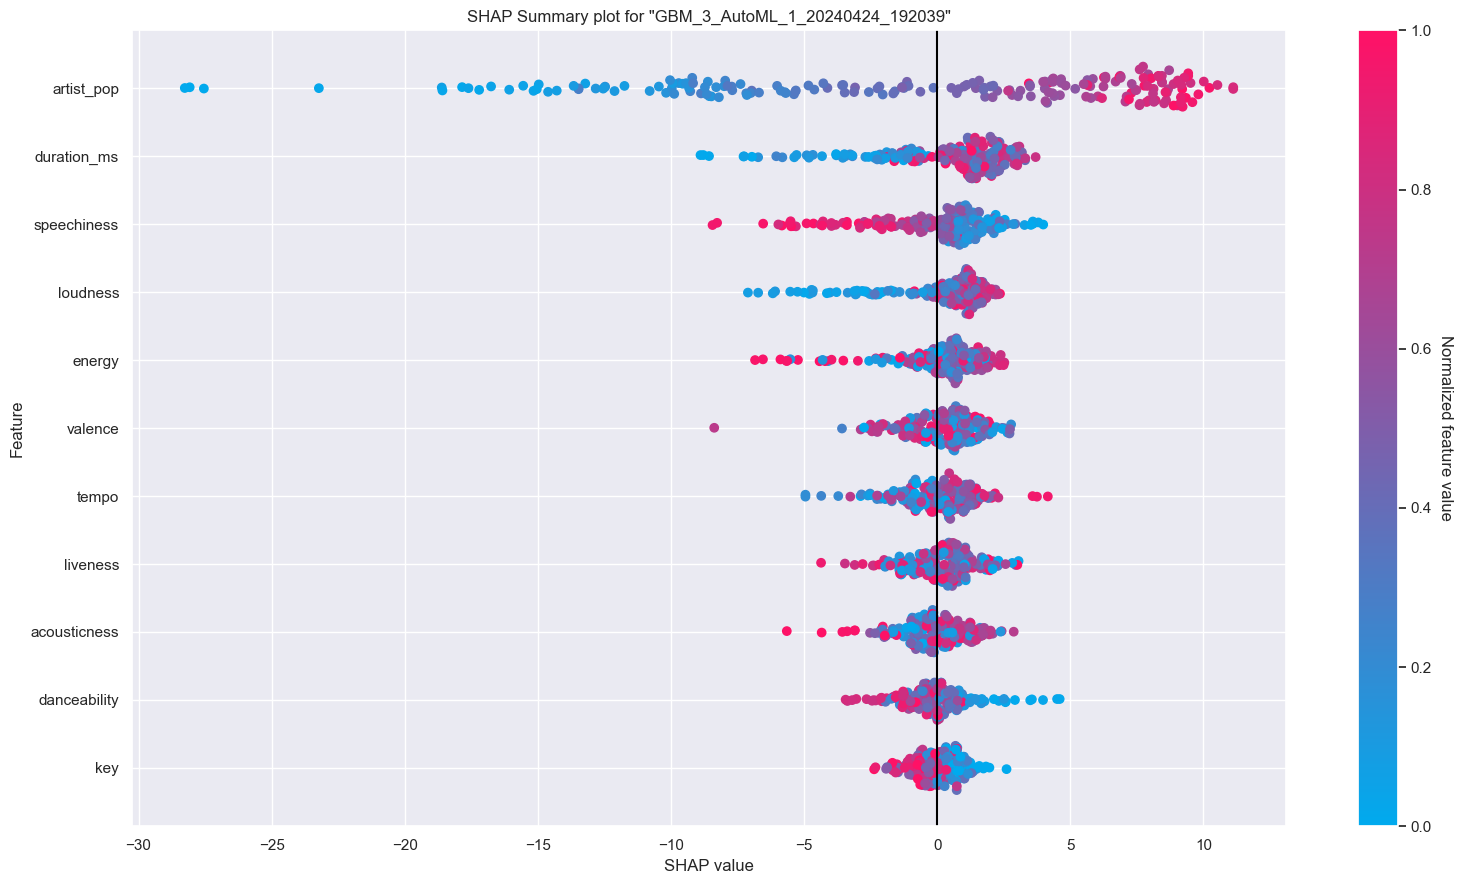

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

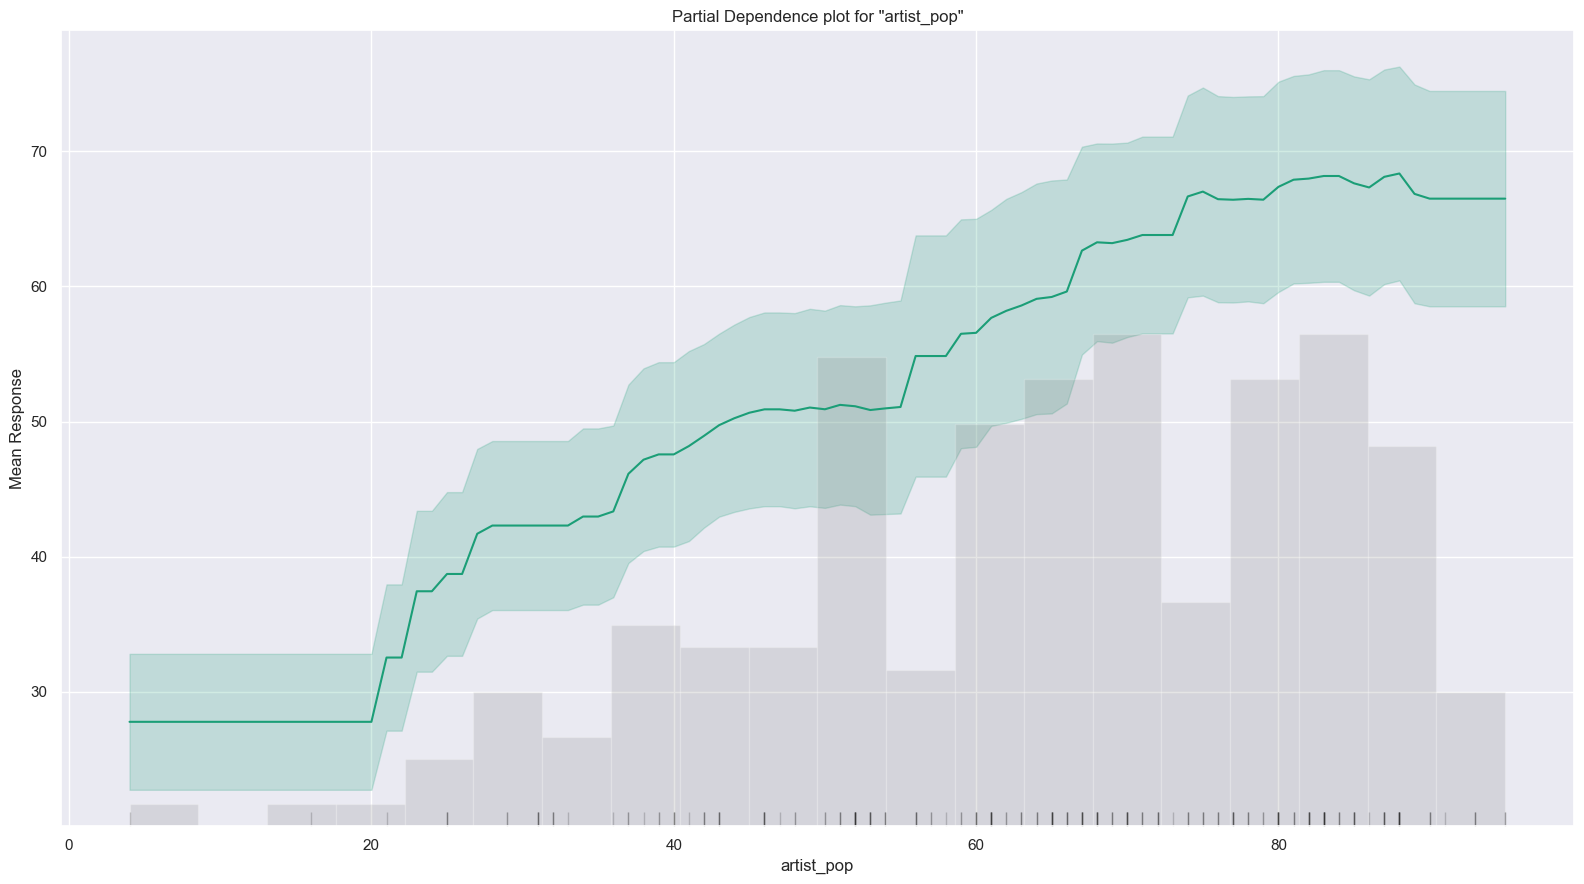

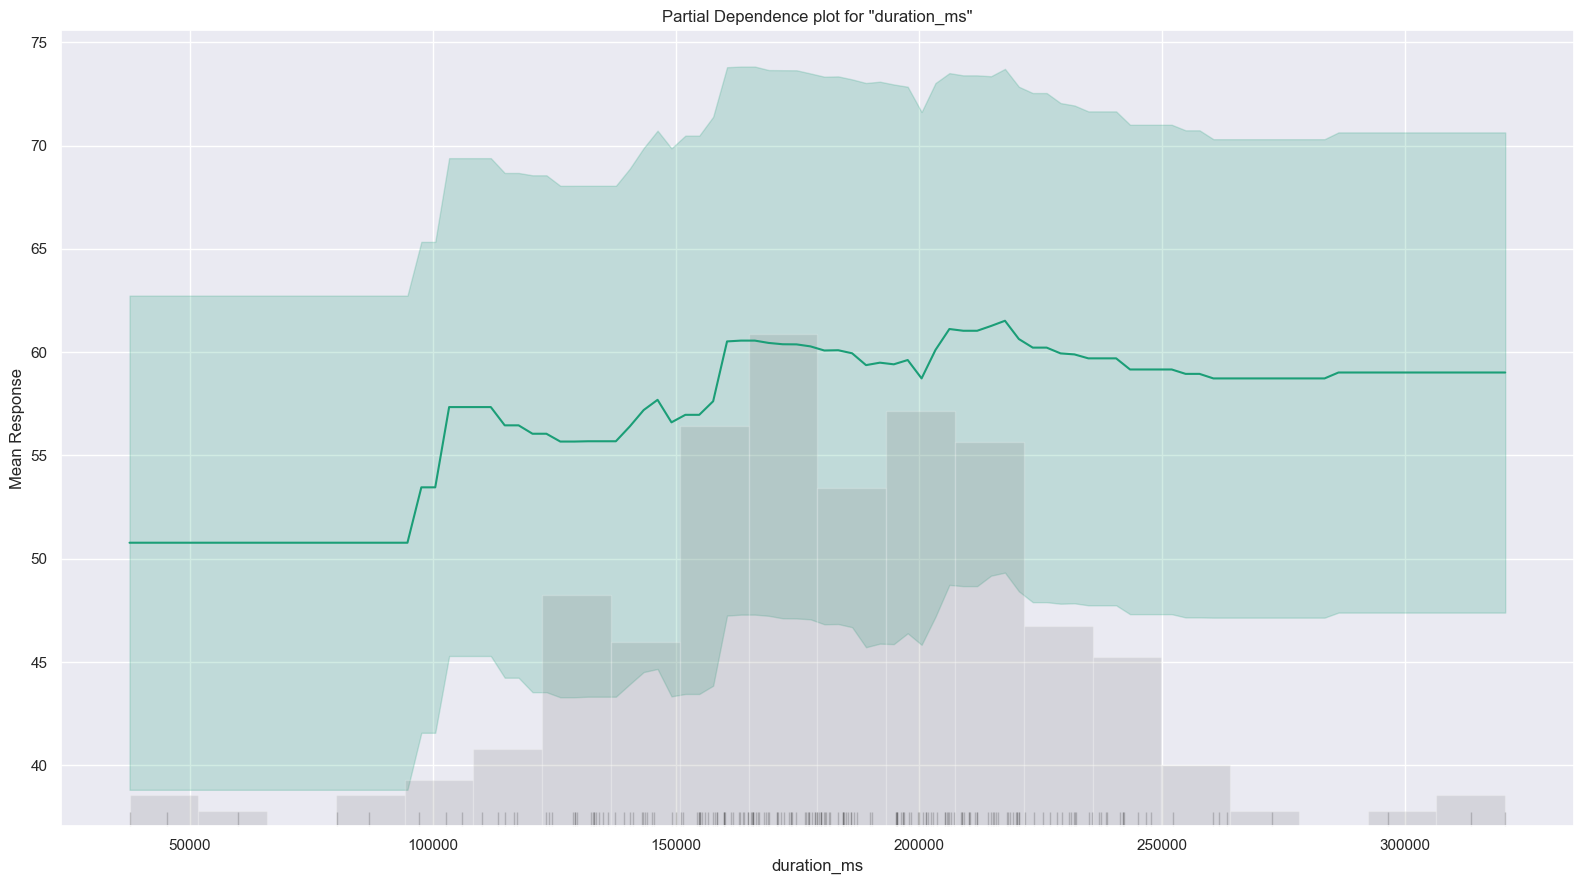

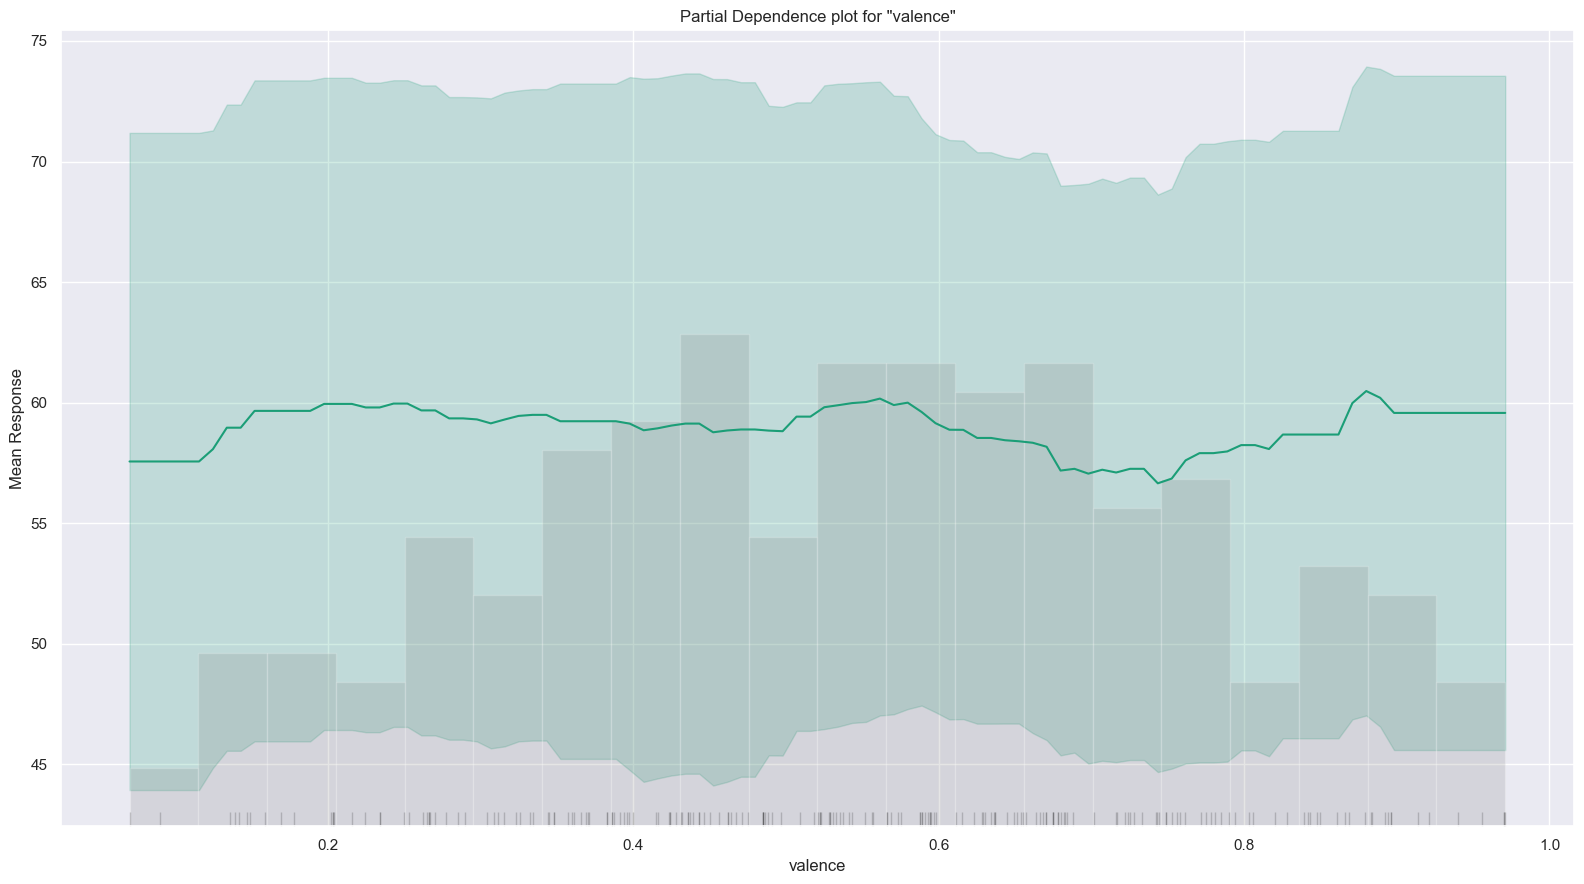

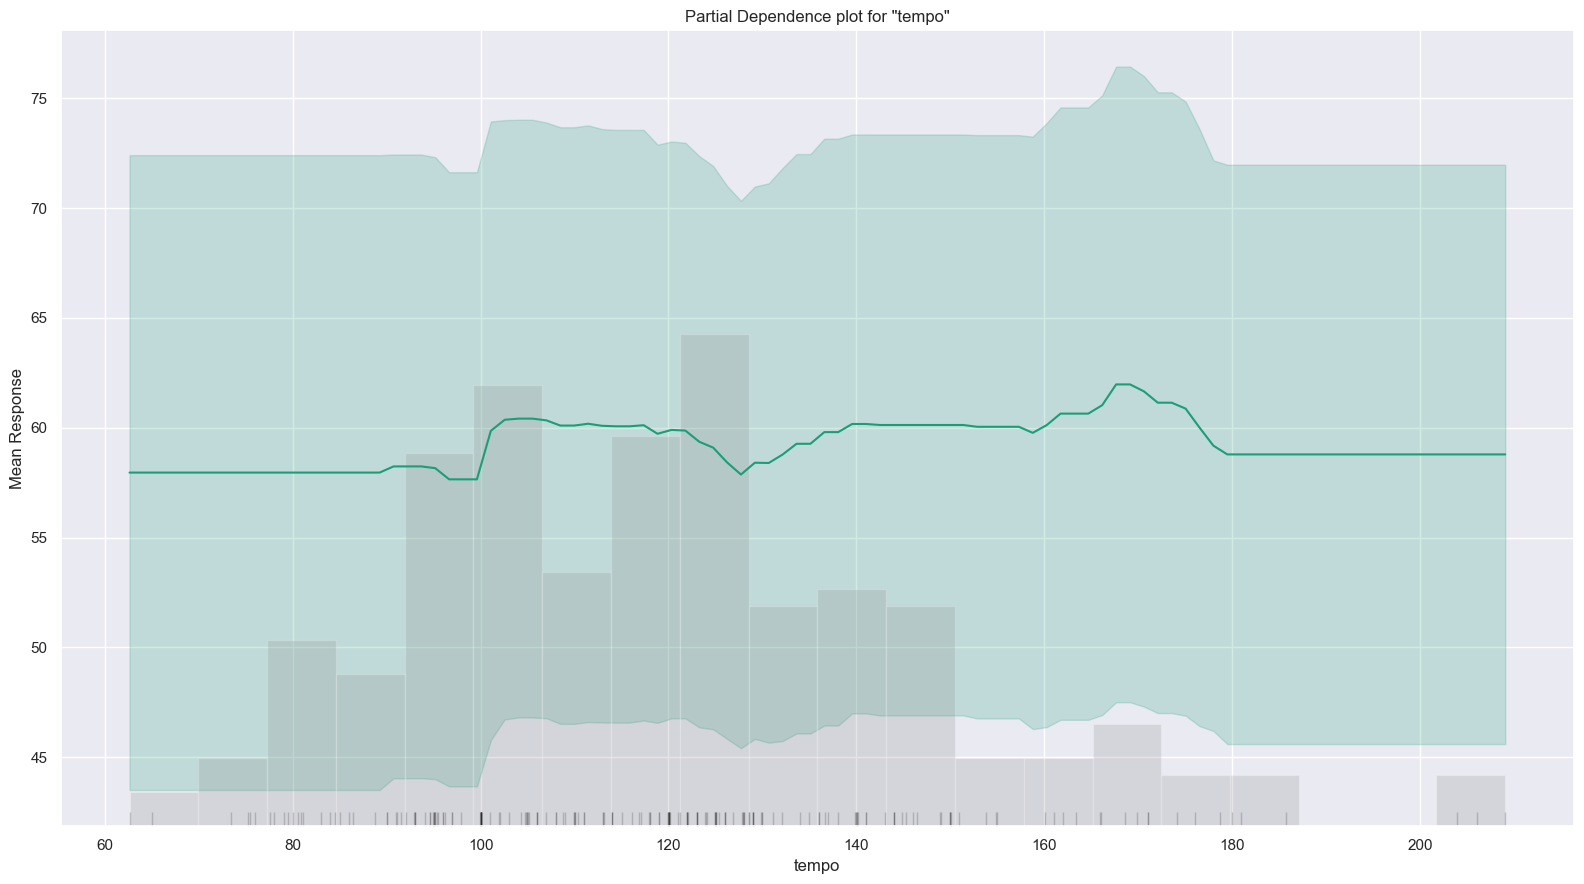

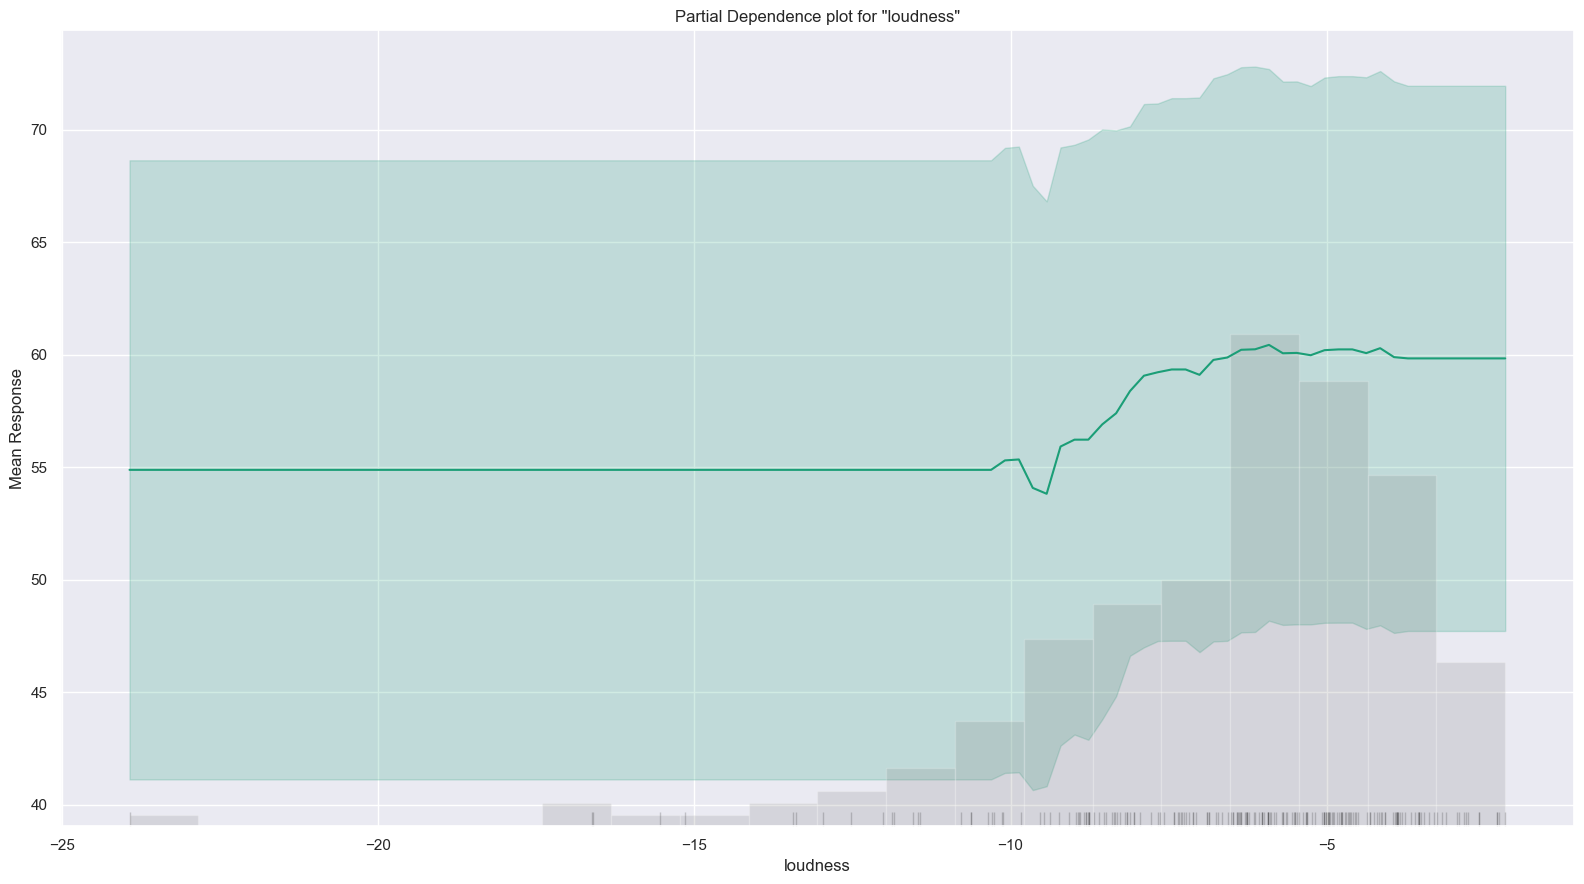

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

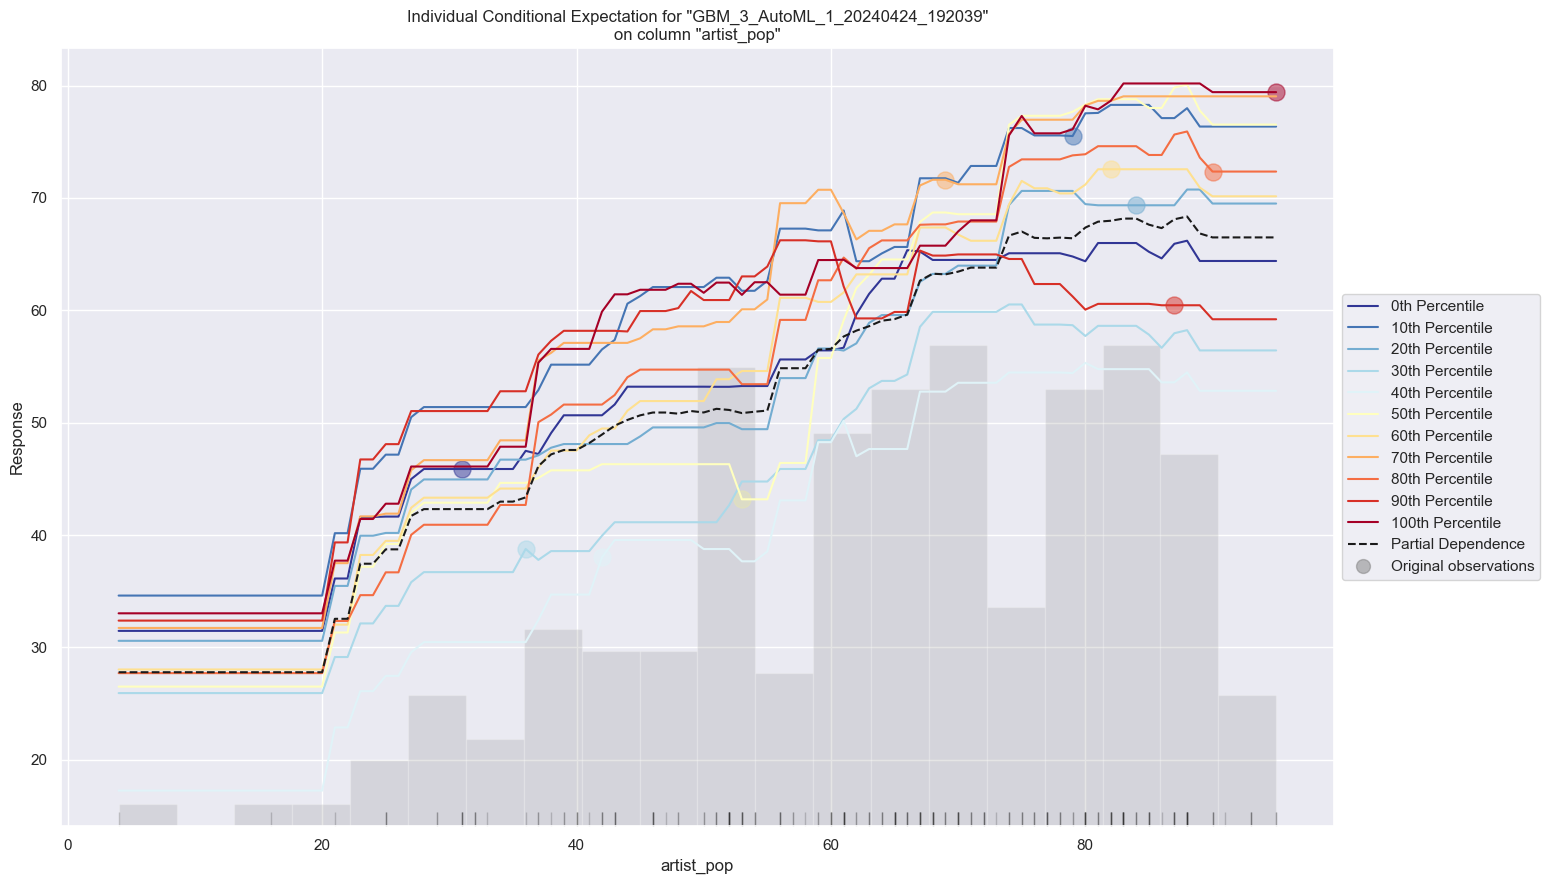

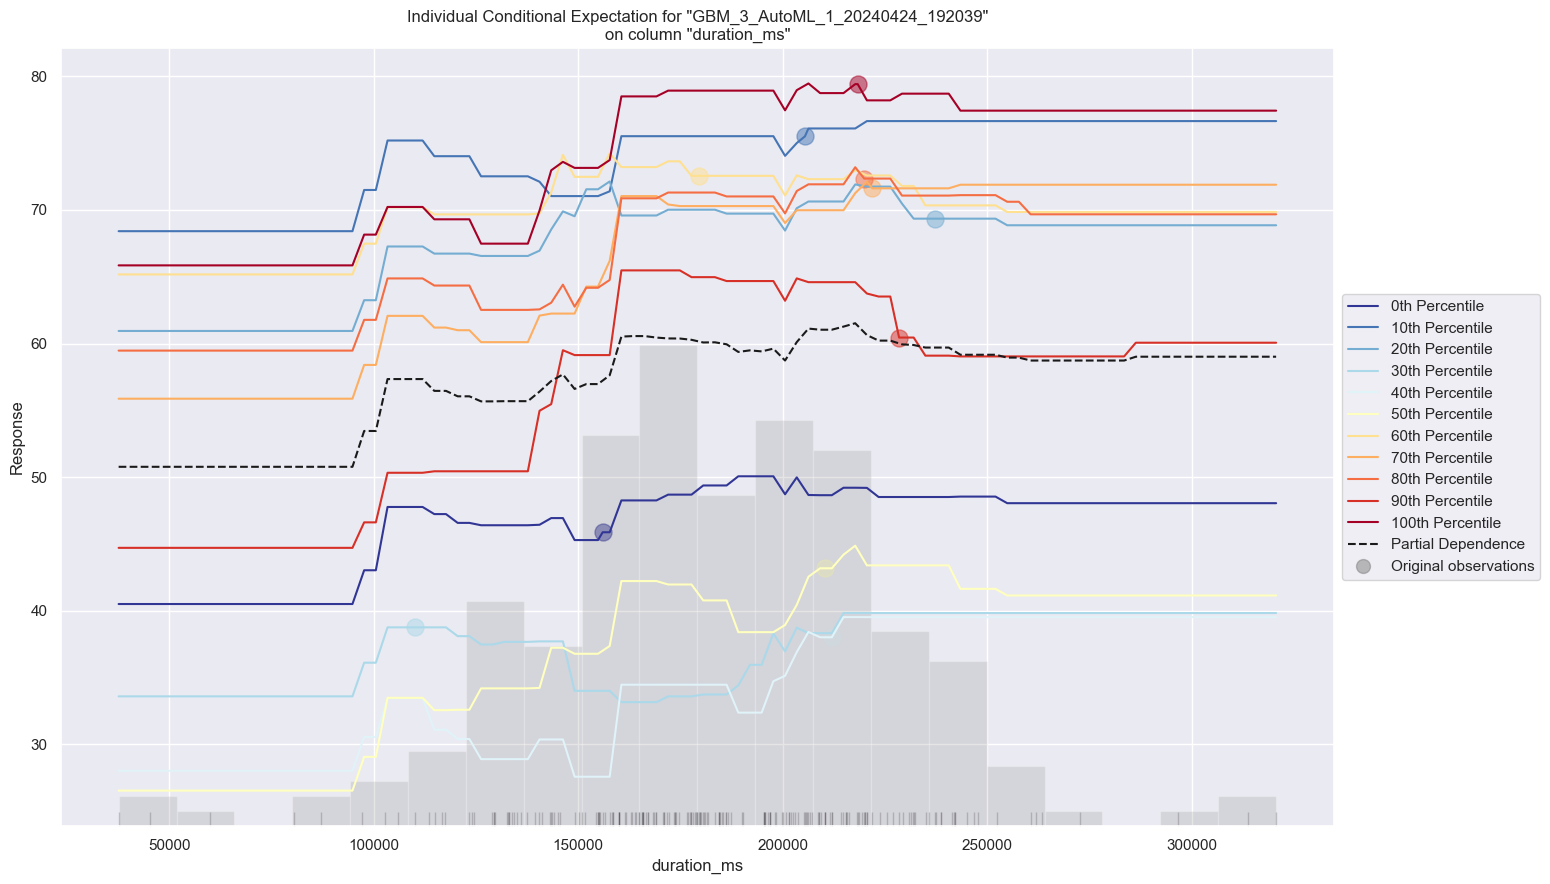

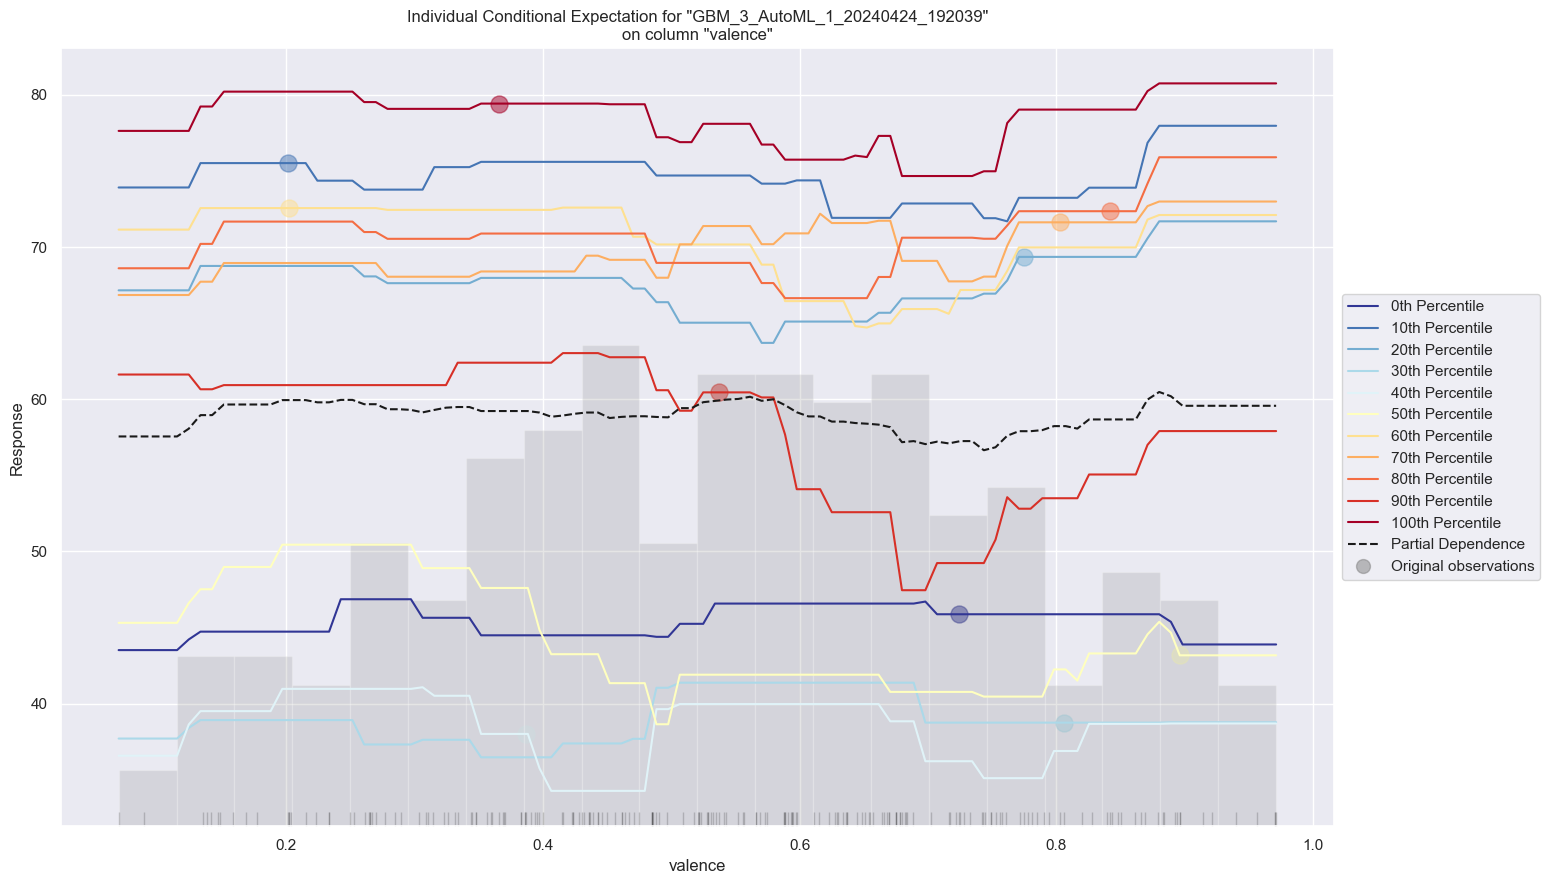

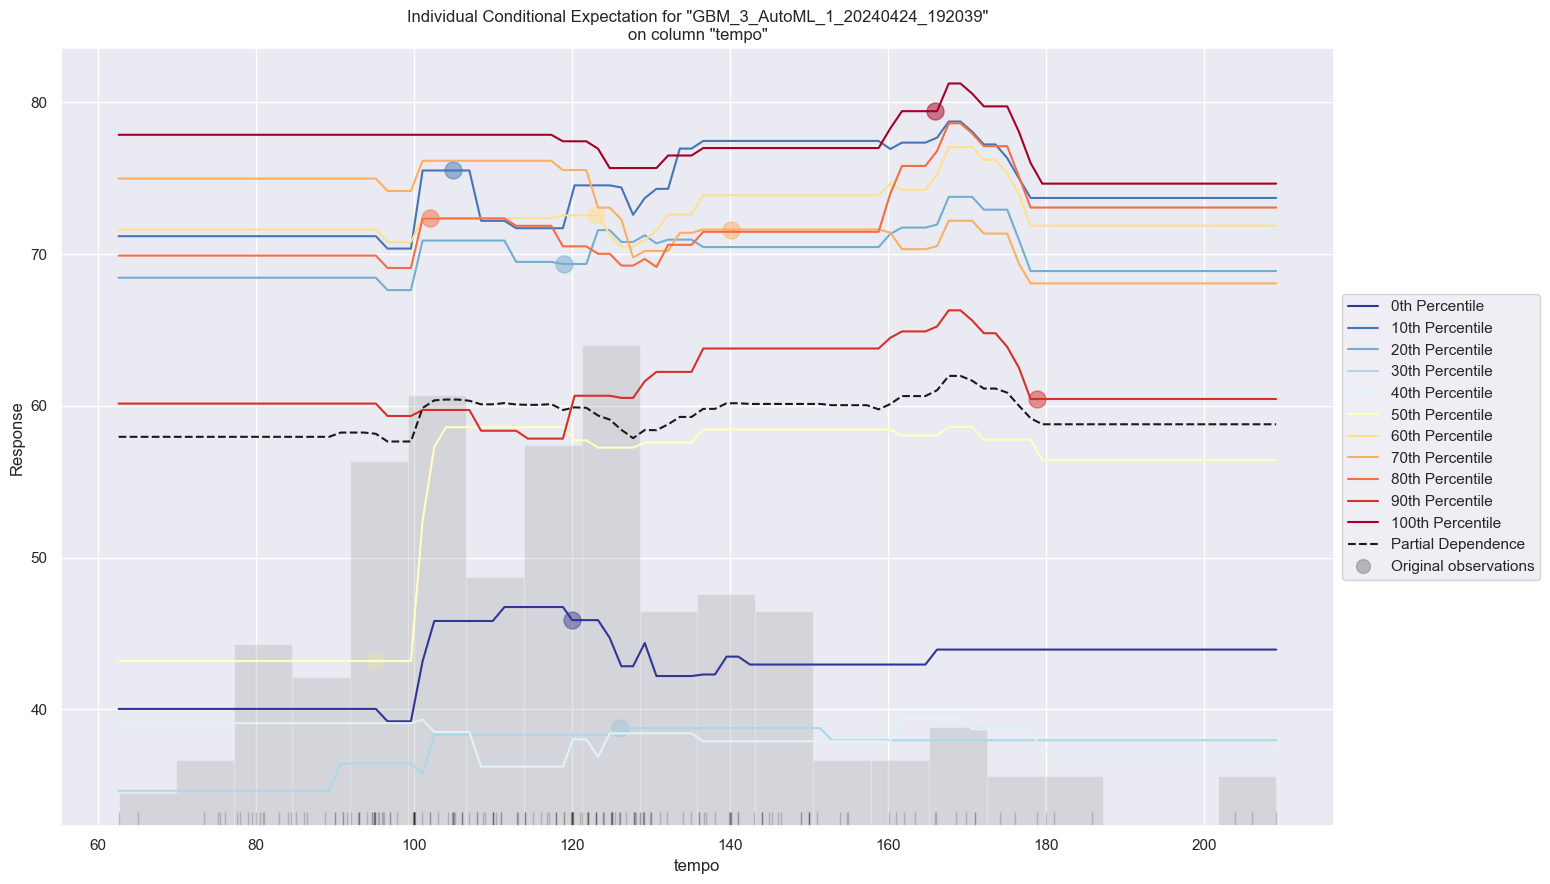

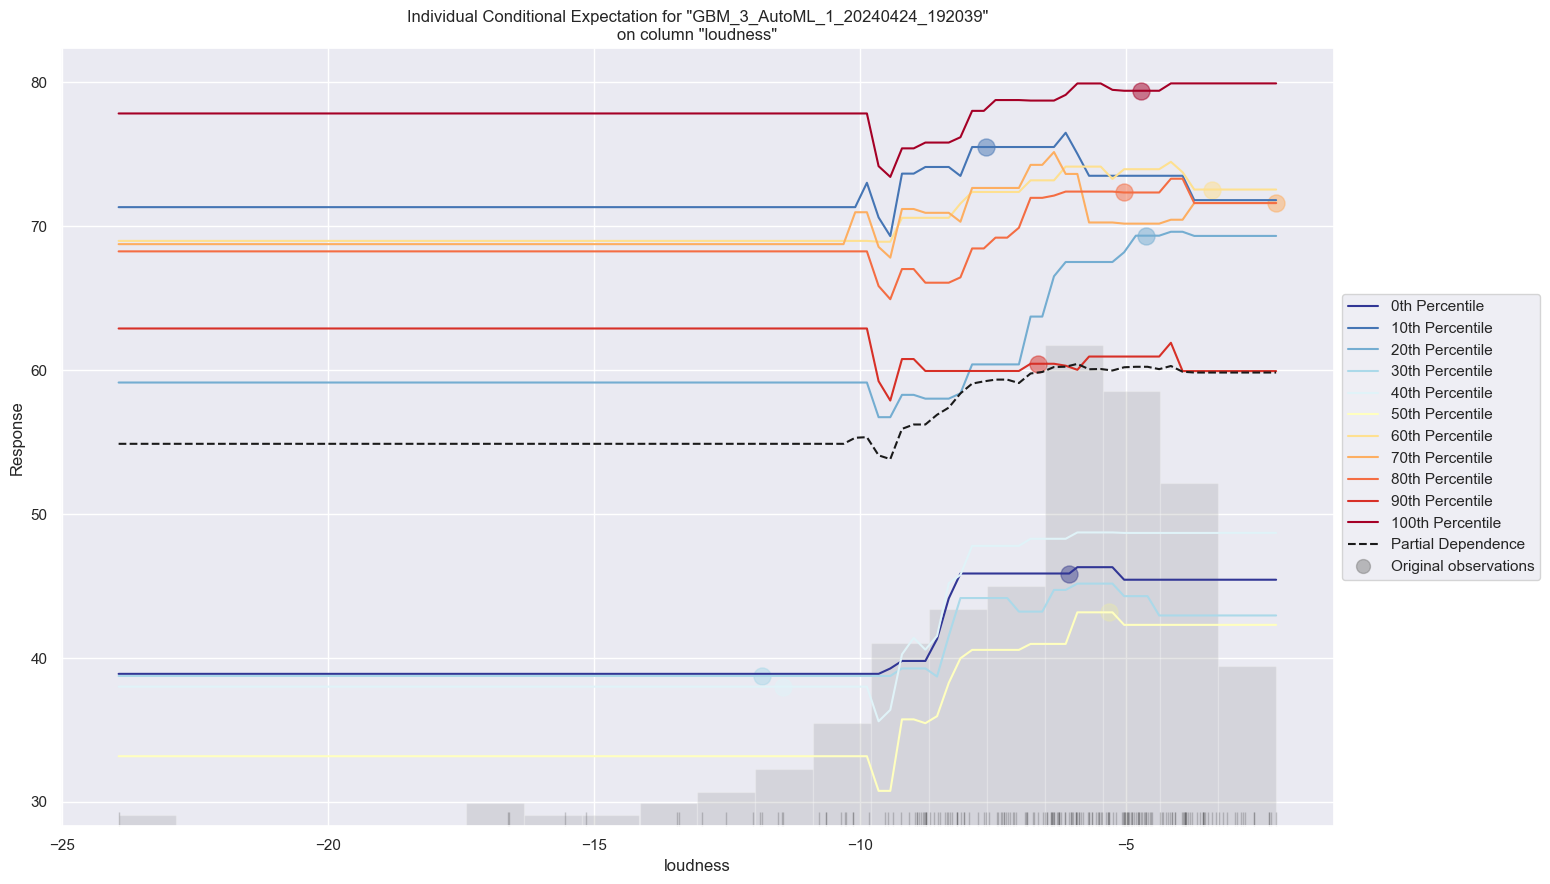

In [20]:
# Explain a single H2O leader model from AutoML
exm = aml.leader.explain(test)

In [21]:
h2o.cluster().shutdown()

H2O session _sid_ad65 closed.


# Phase 2: Clustering Analysis Focused on Musical Qualities

## Selecting musical features for clustering

In [22]:
data = pd.read_csv("Full_DataSet.csv")
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'key', 'mode']
X = data[features]

In [23]:
# Normalizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/weiyew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/weiyew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/weiyew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/weiyew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change fr

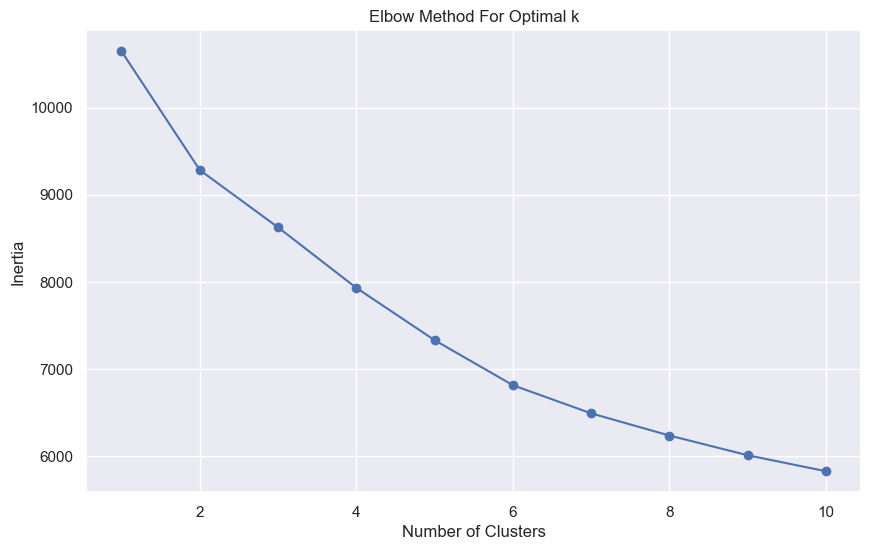

In [24]:
# Finding the optimal number of clusters using the Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

## Analysis of Elbow Method for Optimal K

The Elbow Method helps determine the optimal number of clusters for K-Means clustering. It does this by plotting the inertia (the sum of squared distances between points and their cluster centroids) against the number of clusters. The goal is to find the point where the rate of decrease in inertia slows down, indicating that additional clusters no longer provide substantial benefits.

The optimal number of clusters is usually at the "elbow," where the inertia begins to plateau. In this plot, the elbow seems to be around k=4. This suggests that adding more clusters beyond this point does not significantly improve the within-cluster cohesion.

In [25]:
# Clustering with  4 clusters 
kmeans_4 = KMeans(n_clusters=4, random_state=42)

# Fitting the models
clusters_4 = kmeans_4.fit_predict(X_scaled)

# Adding the cluster information back to the original dataframe for analysis
data['Cluster_4'] = clusters_4

# Describing the clusters for both cluster numbers
cluster_summary_4 = data.groupby('Cluster_4')[features].mean()

cluster_summary_4


/Users/weiyew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


danceability    energy  loudness  speechiness  acousticness  \
Cluster_4                                                                
0              0.771696  0.700562 -5.560389     0.114083      0.145258   
1              0.733800  0.460188 -9.073750     0.176776      0.416915   
2              0.630450  0.733347 -5.768355     0.114702      0.132426   
3              0.702652  0.605565 -9.552826     0.070430      0.375217   

           instrumentalness  liveness   valence       tempo       key  \
Cluster_4                                                               
0                  0.006224  0.130366  0.660184  119.360523  5.154378   
1                  0.008247  0.154126  0.430356  115.547912  5.061538   
2                  0.010570  0.312786  0.460646  133.823944  5.665339   
3                  0.658174  0.158278  0.661235  128.603304  6.260870   

               mode  
Cluster_4            
0          0.548387  
1          0.603846  
2          0.593625  
3          0.695652

In [26]:
# Counting the number of songs in each cluster for the 4-cluster setup
cluster_counts_4 = data['Cluster_4'].value_counts()
cluster_counts_4

Cluster_4
0    434
1    260
2    251
3     23
Name: count, dtype: int64

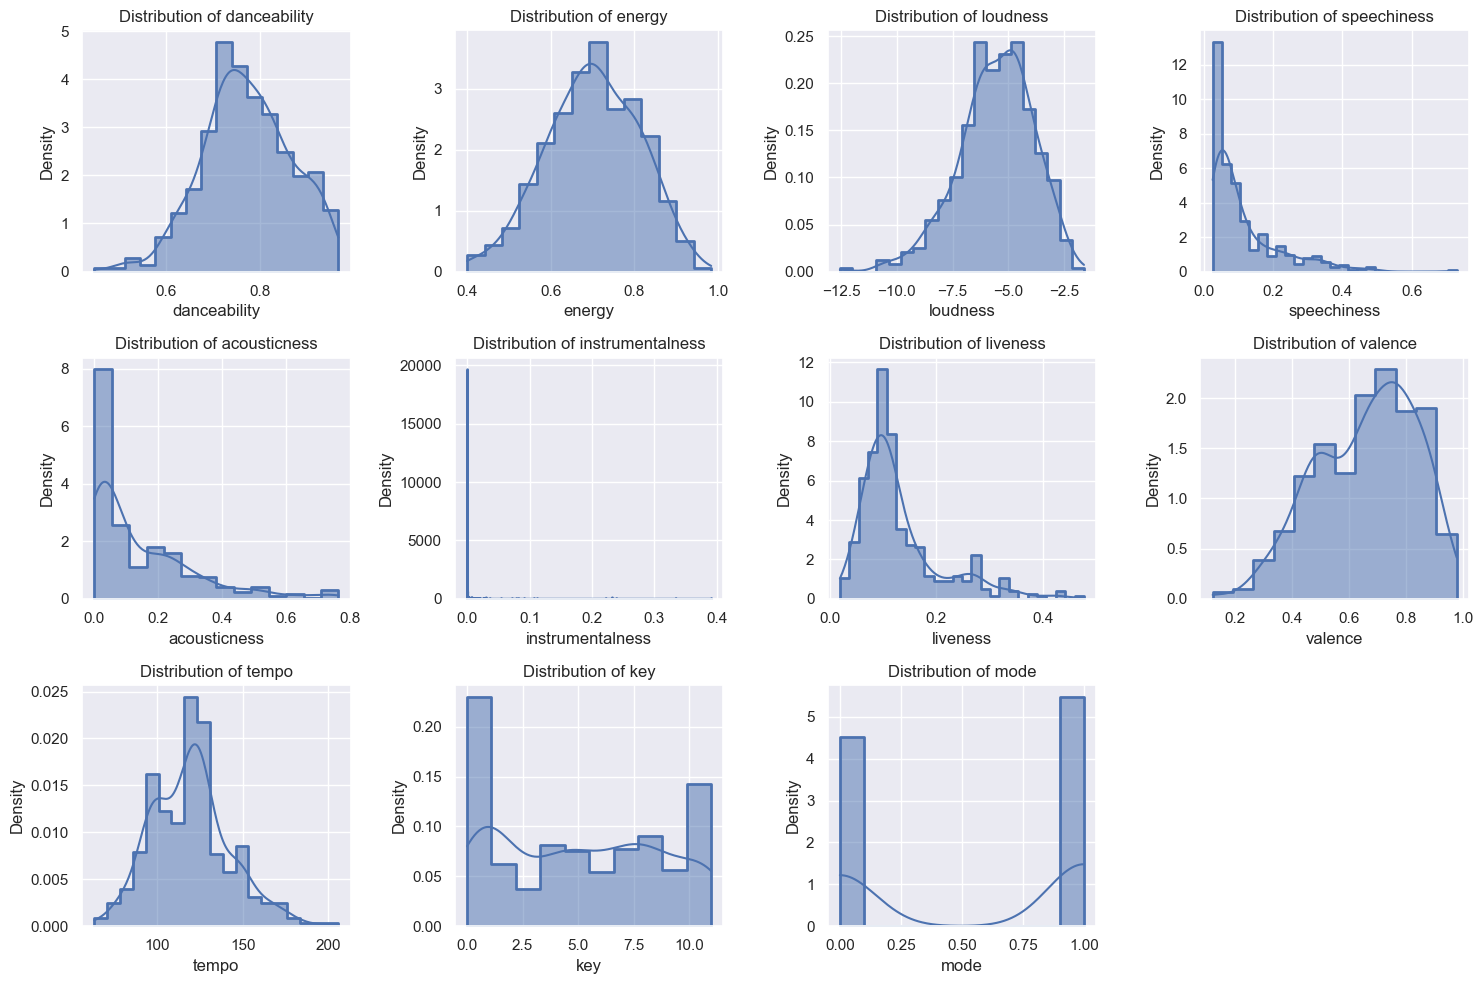

In [27]:
# Filter the data for Cluster 0 from the 4-cluster setup
cluster_4_data = data[data['Cluster_4'] == 0]

# Setting up the plot
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    sb.histplot(cluster_4_data[feature], kde=True, element='step', stat="density", linewidth=2)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

The histograms above show the distributions of various musical features for songs in Cluster 0, which is characterised by:

Danceability: Moderate to high danceability, suggesting these songs have a rhythm and beat that makes them good for dancing, which is often a key factor in TikTok virality.

Energy: Generally high energy levels, indicating that these songs are more intense, which could contribute to their energetic appeal on TikTok.

Loudness: These songs tend to be louder, which may make them more engaging and noticeable, potentially contributing to their popularity.

Speechiness: Mostly lower levels of speechiness, implying that while the songs contain some spoken words, they are not overly dominant.

Acousticness: Low acousticness shows that these songs are more electronic and less organic, aligning with popular music trends on digital platforms.

Instrumentalness: Very low, suggesting that vocal content is important in these tracks, aligning with the trend of using memorable or catchy vocal parts in viral challenges or videos.

Liveness: The liveness is generally low, indicating studio-produced quality, which is typical for commercially successful tracks.

Valence: Medium to high valence, reflecting a positive or cheerful mood, which could enhance their appeal on social platforms.

Tempo: A range of tempos, but generally centered around the medium to fast tempos, which suits active or dynamic video content.

Key and Mode: Distributed across various keys with no clear dominance, and mostly major mode, suggesting a generally upbeat tonal quality.

# T-Test Analysis to Check if the Clusters Are Significantly Different

In [28]:
from scipy.stats import ttest_ind

cluster_0_data = data[data['Cluster_4'] == 0]

# DataFrame to store p-values for t-tests
t_tests_results = pd.DataFrame(index=features, columns=['Cluster_1', 'Cluster_2', 'Cluster_3'])

# Calculate t-tests between Cluster 0 and each of the other clusters
for feature in features:
    for i in range(1, 4):  # Clusters 1, 2, 3
        other_cluster_data = data[data['Cluster_4'] == i]
        stat, p_value = ttest_ind(
            cluster_0_data[feature],
            other_cluster_data[feature],
            equal_var=False
        )
        t_tests_results.at[feature, f'Cluster_{i}'] = p_value

print("T-Test Results:")
t_tests_results

T-Test Results:


Cluster_1 Cluster_2 Cluster_3
danceability      0.000276       0.0  0.008704
energy                 0.0  0.000411  0.023575
loudness               0.0  0.114088  0.000052
speechiness            0.0  0.938731  0.023605
acousticness           0.0  0.322878  0.007514
instrumentalness  0.473066   0.21767       0.0
liveness           0.00174       0.0  0.219735
valence                0.0       0.0  0.983813
tempo             0.048993       0.0  0.124356
key                0.74727  0.078882  0.129391
mode               0.15212  0.249046  0.157321

# Statistical Significance (T-tests)

The t-tests highlight significant differences between "Cluster_0" and the other clusters (Cluster_1, Cluster_2, Cluster_3) across various features.
>Danceability:
The p-values for comparisons between Cluster 0 and Cluster 1 (0.000276), and between Cluster 0 and Cluster 3 (0.008704), indicate significant differences in danceability. This suggests that Cluster_0 has a unique level of danceability compared to these other clusters.

>Energy:
The comparison with Cluster 1 (p = 0.0) indicates a significant difference in energy, suggesting that Cluster 0 is distinctively more energetic than Cluster 1.

>Loudness:
The p-values for comparisons with Cluster 1 (0.0) and Cluster 3 (0.000052) suggest that Cluster 0 differs significantly in loudness.


# Heatmap Visualisation

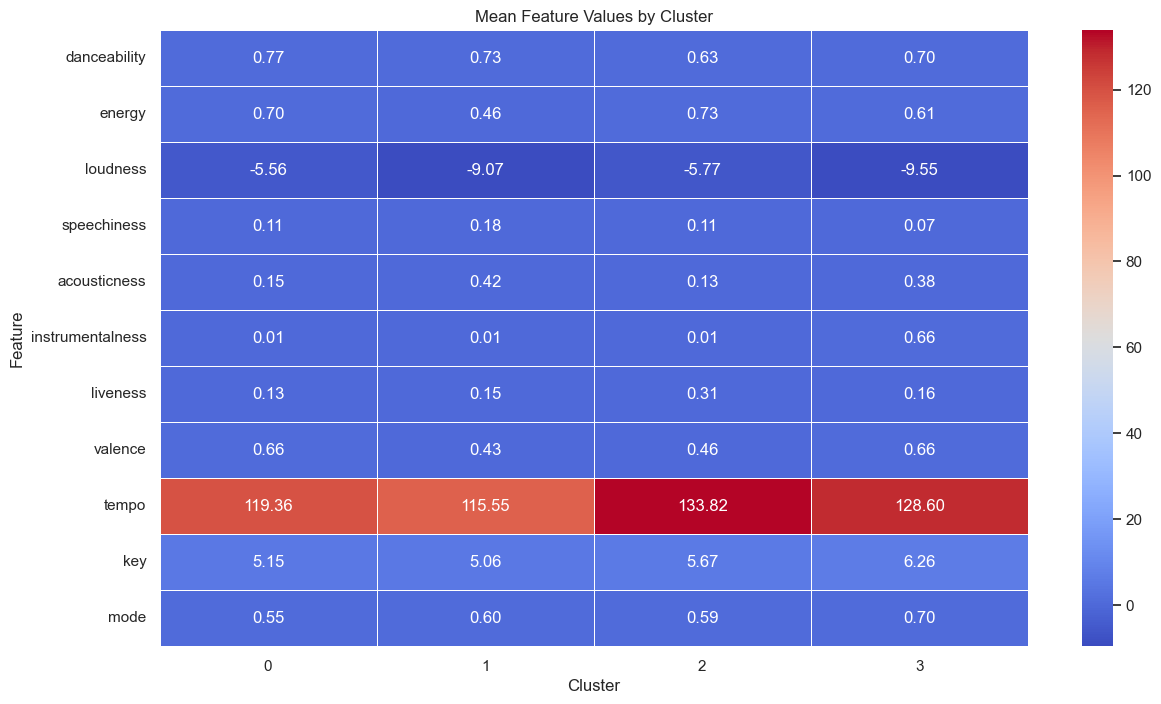

In [29]:
# Calculate the mean values for each cluster
cluster_means = data.groupby('Cluster_4')[features].mean()

# Plot the heatmap of mean feature values by cluster
plt.figure(figsize=(14, 8))
sb.heatmap(
    cluster_means.T,  
    annot=True,  
    fmt=".2f", 
    cmap='coolwarm',  
    linewidths=.5  
)
plt.title('Mean Feature Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()


# Visualisation of Differences

/var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/ipykernel_11611/2857680016.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(cluster_0_data[feature], label='Cluster 0', linewidth=2, shade=True)
/var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/ipykernel_11611/2857680016.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(other_clusters_data[feature], label='Other Clusters', linewidth=2, shade=True)
/var/folders/r1/m5x1qhsn3nvgrf90gt3l6m0h0000gn/T/ipykernel_11611/2857680016.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(cluster_0_data[feature], label='Cluster 0', linewidth=2, shade=True)
/var/folders/r1/m5x1qhsn3nv

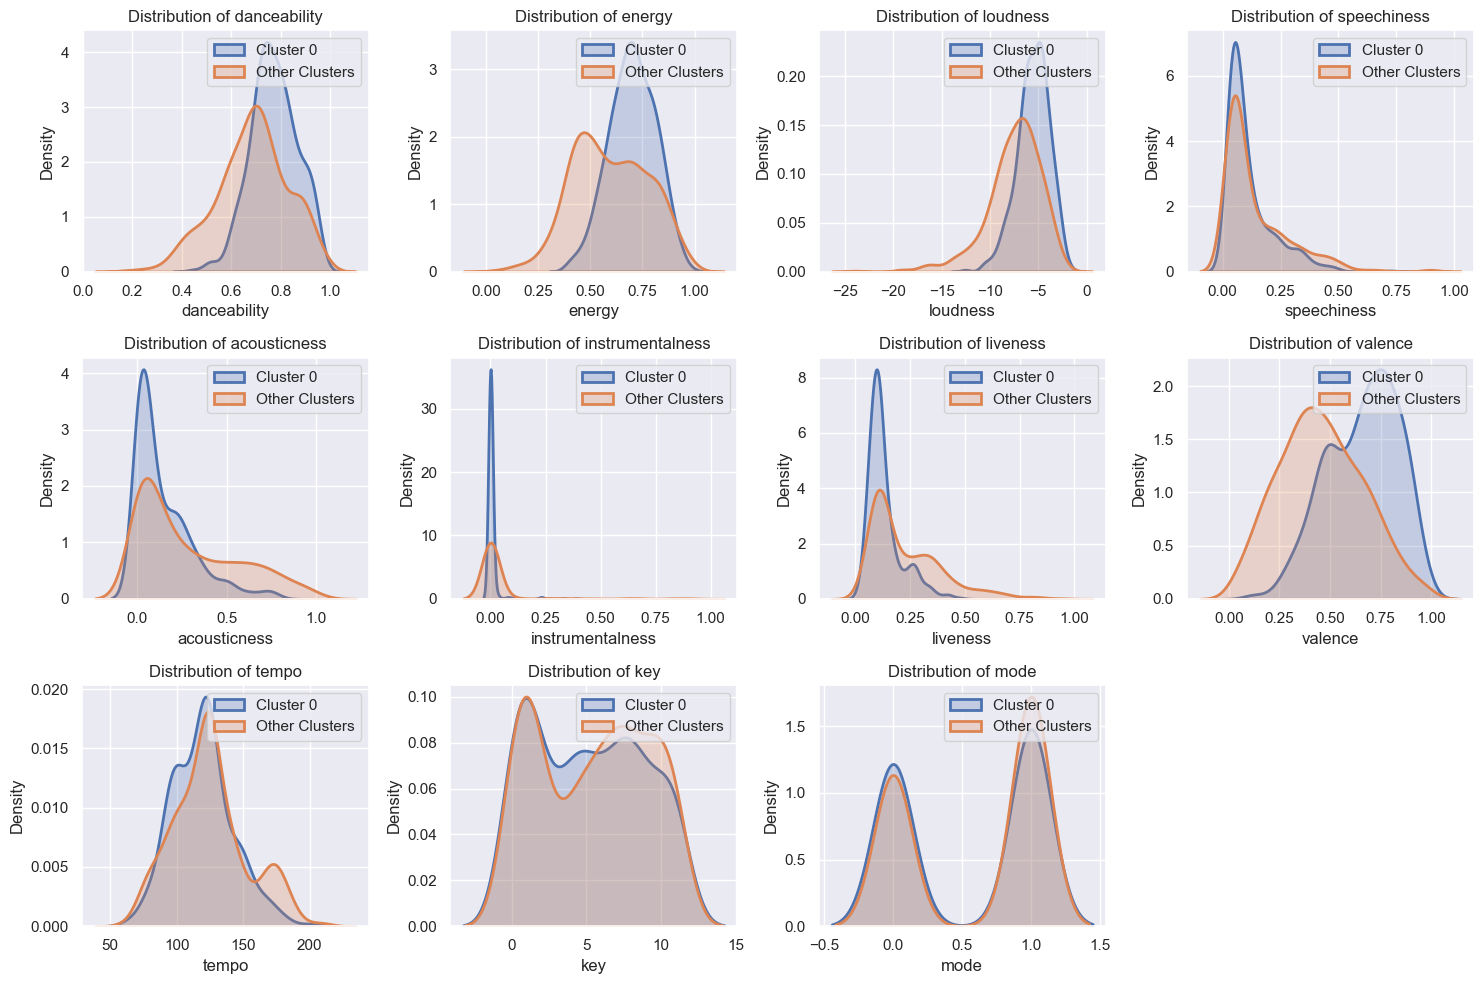

In [30]:
# Features to plot
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
            'instrumentalness', 'liveness', 'valence', 'tempo', 'key', 'mode']

# Cluster 0 data
cluster_0_data = data[data['Cluster_4'] == 0]

# Other clusters data
other_clusters_data = data[data['Cluster_4'] != 0]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(3, 4, i)
    
    # KDE plot for Cluster 0
    sb.kdeplot(cluster_0_data[feature], label='Cluster 0', linewidth=2, shade=True)
    
    # KDE plot for Other Clusters
    sb.kdeplot(other_clusters_data[feature], label='Other Clusters', linewidth=2, shade=True)
    
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


# Interpretation

The analysis of Cluster 0 reveals a unique combination of musical qualities that make this cluster particularly well-suited for virality on TikTok. The attributes identified align with the platform's demand for dynamic, engaging content that drives interaction and user engagement. 

Key characteristics contributing to Cluster 0's appeal include:
>Higher Danceability and Valence: These features suggest that Cluster 0's tracks are designed to be dance-friendly and convey a positive mood, factors likely to attract broader audiences and contribute to virality.

>Increased Energy and Loudness: The energetic and louder nature of these tracks helps capture attention in short-form content, which is crucial for TikTok's fast-paced environment.

>Lower Acousticness: The preference for less acoustic and more produced sounds indicates alignment with modern production trends and TikTok's focus on high-energy content.


# Reflection

TikTok has transformed the way music goes viral. 

While traditional music popularity often relies on the star power of established artists, TikTok has shown that even lesser-known tracks can explode into the spotlight. 

### The Vibe That Captures Attention
TikTok is all about energy, rhythm, and a touch of fun. Cluster 0 embodies these elements, with high danceability and valence that make the tracks irresistibly catchy. These aren't just songs—they're experiences that make you want to create, dance, and share. On TikTok, it's the music that gets you moving, not necessarily the artist behind it.

### Loudness and Energy
TikTok's short-form content demands immediate engagement, and the louder, more energetic tracks in Cluster 0 are perfect for this. They burst onto the scene, grabbing attention in just a few seconds. This high-impact approach is key to TikTok's viral success—it doesn't matter who sings the song; it's all about the impact it makes.

### The Beat of TikTok
The right beat can set the tone for thousands of videos, creating trends that spread like wildfire. 

### Conclusion
Unlike traditional music platforms, where artist popularity can heavily influence track success, TikTok is a level playing field where the music's energy and vibe matter most. The music's energy, rhythm, and unique qualities could equally drive its success. While artist popularity might impact track_pop globally, TikTok is its own world—a place where creativity, engagement, and the right vibe can turn any track into a viral sensation.